# Compute Resource Allocation

In [1]:
### I am going to spool an AWS instance as my local enviornment is broken at the moment. I am checking to see if I am on the right instance below with each run.
import subprocess
import psutil
values = psutil.virtual_memory()
total = values.total >> 30

cpuinfo=((subprocess.check_output("lscpu", shell=True).strip()).decode()).splitlines()

for i in cpuinfo[0:8]:
    print(i)
print('Total Ram: {} Gb'.format(str(total).rjust(25)))

Architecture:                    x86_64
CPU op-mode(s):                  32-bit, 64-bit
Address sizes:                   48 bits physical, 48 bits virtual
Byte Order:                      Little Endian
CPU(s):                          64
On-line CPU(s) list:             0-63
Vendor ID:                       AuthenticAMD
Model name:                      AMD EPYC 7R13 Processor
Total Ram:                       123 Gb


# 1. Data Survey


A Data Survey:
The Ames housing dataset represents residential property sales in Ames, Iowa from 2006 to 2010. The dataset includes a vast range of variables, totaling to 80 independent features that capture almost every aspect of residential homes. These features encompass a multitude of aspects including the physical properties of the dwelling (like area, number of rooms, type of utilities), the quality and condition of various elements of the property (exteriors, kitchen, heating, etc.), time-related information (year built, year remodeled), neighborhood details, and various other attributes (e.g., proximity to main road or railway).

With our objective of predicting the value of a property, the dataset seems quite appropriate given its comprehensive set of housing-related variables that are likely to influence property value. However, the extensive nature of this dataset may include features that may not have a strong influence on the target variable and hence, feature selection would be a crucial aspect of model development. Additionally, the presence of missing values in many of the columns necessitates thorough data cleaning and imputation.

Although the data provides a wide spectrum of information about the properties, some observations should be treated with caution. Properties with extreme characteristics or values, such as very high square footage or highly unusual features, may act as outliers and could potentially distort the model's predictions. It would be prudent to explore the dataset for such outliers and decide how to handle them, either through exclusion, transformation, or robust modeling techniques.

Given the dataset, we can address a variety of questions related to property valuation, such as identifying key drivers of property price, analyzing the influence of various property features on price, predicting property prices, and more. We can build a regression model with SalePrice as the target variable, with the understanding that we are predicting the price of residential properties in Ames, Iowa specifically between 2006 and 2010. However, it's crucial to keep in mind that the model's applicability might be limited to similar real estate markets and periods, given market dynamics and inflation effects.

Lastly, the dataset does not include information about the price per square foot, which is often a key metric in real estate valuation. If we were to generate this feature, it would allow us to assess property value in a more standardized way, accounting for differences in size. However, as it stands, the data allows us to estimate overall sale prices, assuming that we appropriately handle the complexities of the data, including missing data, outliers, and skewed distributions.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = pd.read_csv("ames_housing_data.csv")
df['TotalFloorSF'] = df['FirstFlrSF'] + df['SecondFlrSF']
df['HouseAge'] = df['YrSold'] - df['YearBuilt']
df['QualityIndex'] = df['OverallQual'] * df['OverallCond']
df['logSalePrice'] = np.log(df['SalePrice'])
df['price_sqft'] = df['SalePrice'] / df['TotalFloorSF']
print(df.shape)
print(df.info())
print(df.head())
print(df.columns)
print(df['price_sqft'].describe())

(2930, 87)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 87 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   SID            2930 non-null   int64  
 1   PID            2930 non-null   int64  
 2   SubClass       2930 non-null   int64  
 3   Zoning         2930 non-null   object 
 4   LotFrontage    2440 non-null   float64
 5   LotArea        2930 non-null   int64  
 6   Street         2930 non-null   object 
 7   Alley          198 non-null    object 
 8   LotShape       2930 non-null   object 
 9   LandContour    2930 non-null   object 
 10  Utilities      2930 non-null   object 
 11  LotConfig      2930 non-null   object 
 12  LandSlope      2930 non-null   object 
 13  Neighborhood   2930 non-null   object 
 14  Condition1     2930 non-null   object 
 15  Condition2     2930 non-null   object 
 16  BldgType       2930 non-null   object 
 17  HouseStyle     2930 non-null   object 
 1

In [3]:
df=df.replace('None', pd.NaT)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 87 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   SID            2930 non-null   int64  
 1   PID            2930 non-null   int64  
 2   SubClass       2930 non-null   int64  
 3   Zoning         2930 non-null   object 
 4   LotFrontage    2440 non-null   float64
 5   LotArea        2930 non-null   int64  
 6   Street         2930 non-null   object 
 7   Alley          198 non-null    object 
 8   LotShape       2930 non-null   object 
 9   LandContour    2930 non-null   object 
 10  Utilities      2930 non-null   object 
 11  LotConfig      2930 non-null   object 
 12  LandSlope      2930 non-null   object 
 13  Neighborhood   2930 non-null   object 
 14  Condition1     2930 non-null   object 
 15  Condition2     2930 non-null   object 
 16  BldgType       2930 non-null   object 
 17  HouseStyle     2930 non-null   object 
 18  OverallQ

# 2.Define the Sample Population:
When we set out to build a predictive model, it's crucial to define the population that the model is intended to serve. In this case, our aim is to estimate home values for "typical" homes in Ames, Iowa. Defining what constitutes "typical" may be subjective, but we can utilize the data to discern what might be considered "atypical". By excluding these atypical observations, we effectively define our population of interest.

In the context of our objective, it is necessary to clarify that not all properties are created equal. The value of a property can vary drastically based on its type. For example, a single-family residence, an apartment building, a warehouse, or a shopping center each carry different value propositions, driven by different factors. Including all these different types of properties in the same model would complicate the interpretation of our results and might lead to erroneous conclusions.

Therefore, for our purpose, it would be sensible to focus on single-family residences, as these constitute a significant portion of residential property transactions and represent a homogeneous category of properties, making our model more interpretable and robust.

We can define our sample population using a series of 'drop conditions'. For instance, we can exclude observations where the 'BldgType' (Building Type) is not '1Fam' (Single-family Detached). Similarly, we may also want to exclude properties with extremely high or low values of 'GrLivArea' (Above grade (ground) living area square feet) as they could represent atypical properties.

The 'drop conditions' are listed below as follows:

## Data Quality

### Null Analysis and Cleanup (Nulls Represent Below in White)

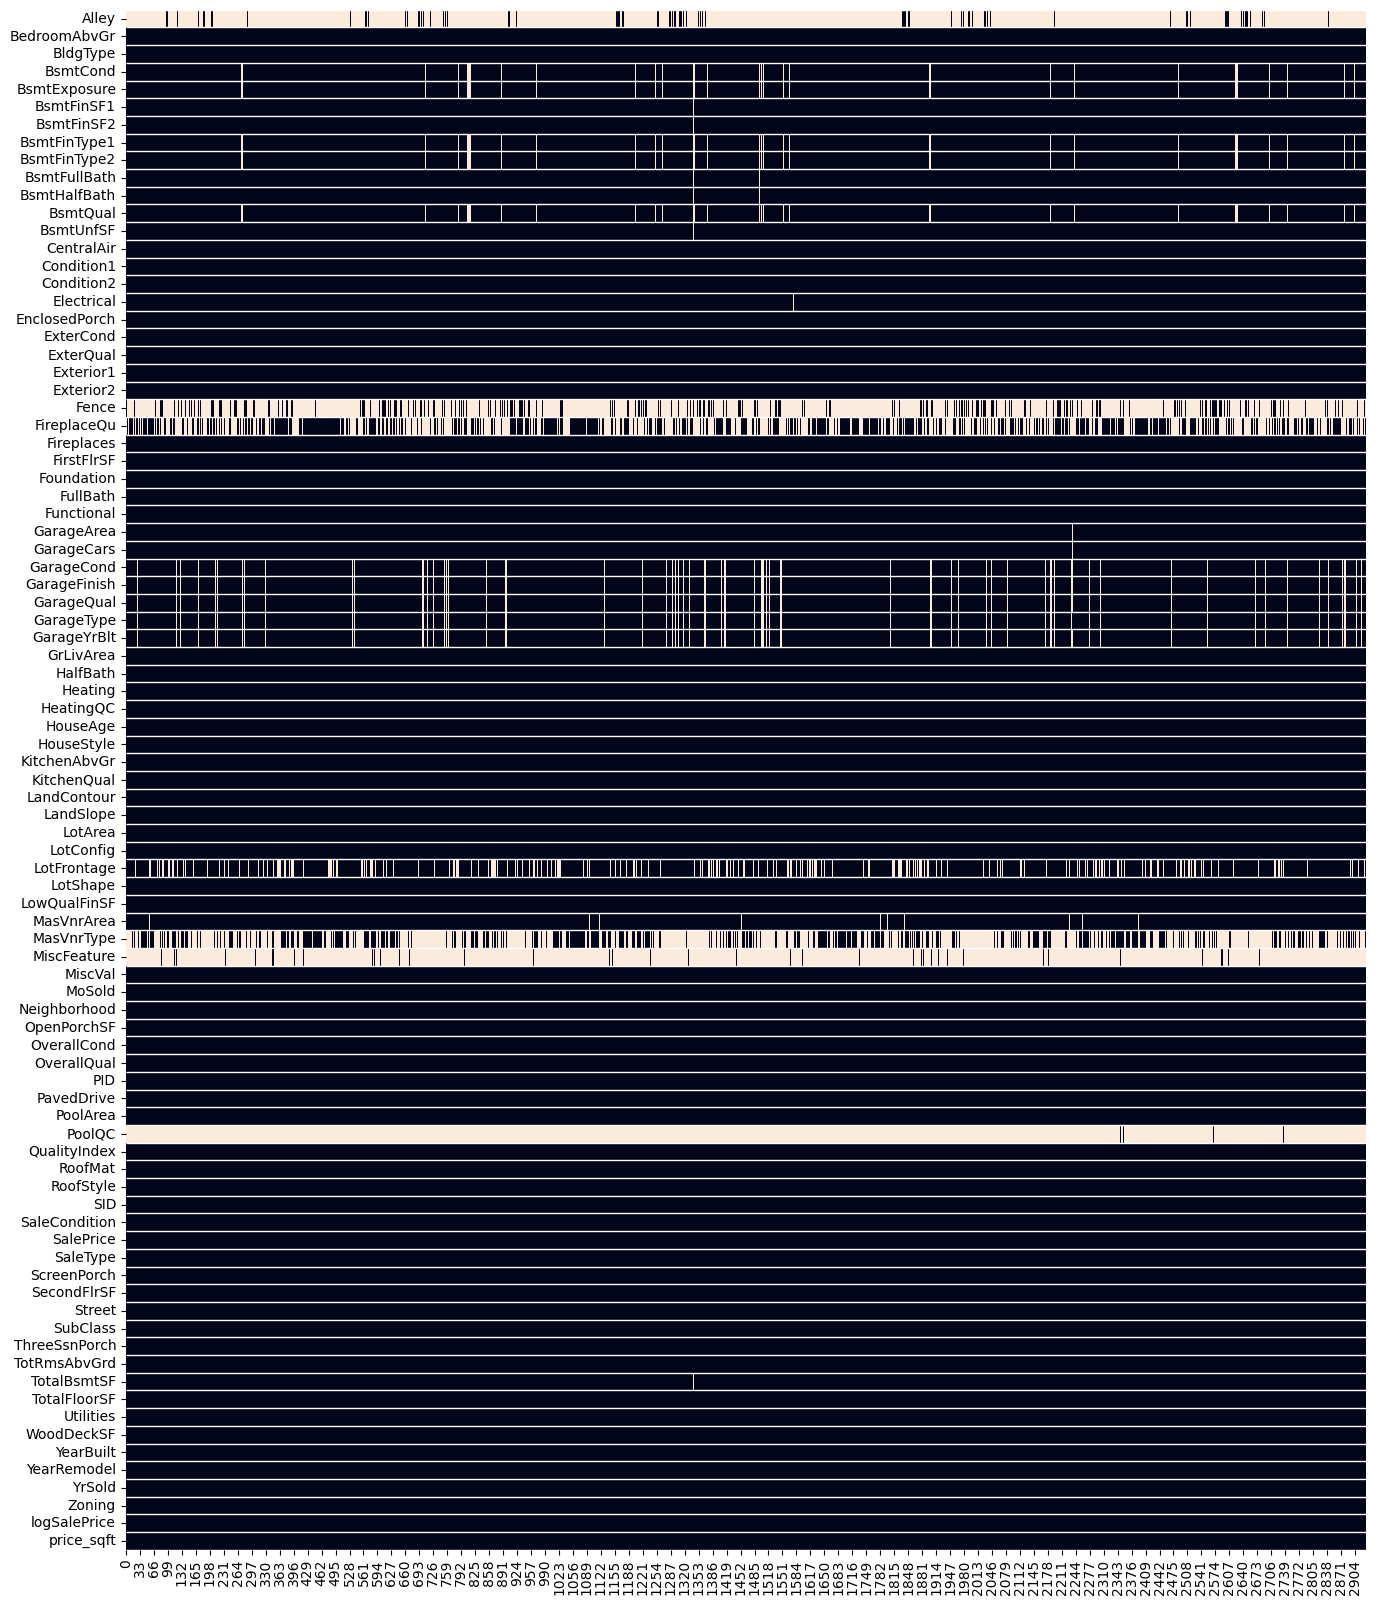

In [4]:
fig, ax = plt.subplots(figsize=(16, 20))
plt.rcParams["axes.grid"] = True

df_heat=df.sort_index(axis=1, ascending=False)
sns.heatmap(df_heat.T.isnull(), ax=ax, cbar=False).invert_yaxis()
ax.hlines(range(len(df_heat)), *ax.get_xlim(), color='white', linewidths=1)
ax.vlines([], [], [])
plt.yticks(rotation = 360)
plt.show()

In [5]:
Nulls=[]
for i in df.columns:
    if df[i].isnull().sum() > 0:
        Nulls.append(i)
        print("Column: {} Null Count: {}".format((i+"                      ")[0:18], df[i].isnull().sum()))
        

Column: LotFrontage        Null Count: 490
Column: Alley              Null Count: 2732
Column: MasVnrType         Null Count: 1775
Column: MasVnrArea         Null Count: 23
Column: BsmtQual           Null Count: 80
Column: BsmtCond           Null Count: 80
Column: BsmtExposure       Null Count: 83
Column: BsmtFinType1       Null Count: 80
Column: BsmtFinSF1         Null Count: 1
Column: BsmtFinType2       Null Count: 81
Column: BsmtFinSF2         Null Count: 1
Column: BsmtUnfSF          Null Count: 1
Column: TotalBsmtSF        Null Count: 1
Column: Electrical         Null Count: 1
Column: BsmtFullBath       Null Count: 2
Column: BsmtHalfBath       Null Count: 2
Column: FireplaceQu        Null Count: 1422
Column: GarageType         Null Count: 157
Column: GarageYrBlt        Null Count: 159
Column: GarageFinish       Null Count: 159
Column: GarageCars         Null Count: 1
Column: GarageArea         Null Count: 1
Column: GarageQual         Null Count: 159
Column: GarageCond         Null 

### LotFrontage 


In [6]:
df['LotFrontage']=df['LotFrontage'].fillna(df['LotFrontage'].median())

### Alley


In [7]:
df['Alley']=df['Alley'].fillna('No alley')

### MasVnrType & MasVnrArea: Filling with None and 0

In [8]:
df['MasVnrType']=df['MasVnrType'].fillna('None')
df['MasVnrArea']=df['MasVnrArea'].fillna(0)

### BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2

In [9]:
for col in ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']:
    df[col].fillna('No basement')

### Categorical garage-related columns (fill with 'No garage' or 0 because NaN likely means no garage). For the year we will fill it with the median.

In [10]:
for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    if df[col].dtype == 'object':
        df[col]=df[col].fillna('No garage')
    else:
        df[col]=df[col].fillna('None')

df['GarageYrBlt']=df['GarageYrBlt'].fillna(df['GarageYrBlt'].median())

### Numeric garage-related columns: Fill with zero Assuming there is no garage.

In [11]:
  
df['GarageCars']=df['GarageCars'].fillna(0)
df['GarageArea']=df['GarageArea'].fillna(0)

#### PoolQC: fill with 'No pool' because NaN likely means no pool

In [12]:
df['PoolQC']=df['PoolQC'].fillna('No pool')


### Fence: fill with 'No fence' because NaN likely means no fence

In [13]:
df['Fence']=df['Fence'].fillna('No fence')

### MiscFeature: fill with 'No feature' because NaN likely means there are no additional features


In [14]:
df['MiscFeature']=df['MiscFeature'].fillna('No feature')

### Electrical: As this is a categorical feature, we can replace missing values with the most common class

In [15]:
df['Electrical']=df['Electrical'].fillna(df['Electrical'].mode()[0])

### FireplaceQu: NaN probably means no fireplace

In [16]:
df['FireplaceQu']=df['FireplaceQu'].fillna('No fireplace')

### BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, and BsmtFinType2: Fill missing categorical basement columns with 'No basement'

In [17]:
for col in ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']:
    df[col]=df[col].fillna('No basement')

### BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath, & BsmtHalfBath: Fill missing numerical basement columns with 0

In [18]:
for col in ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']:
    df[col]=df[col].fillna(0)

## Here is our cleaned dataset

### No Rows were dropped.

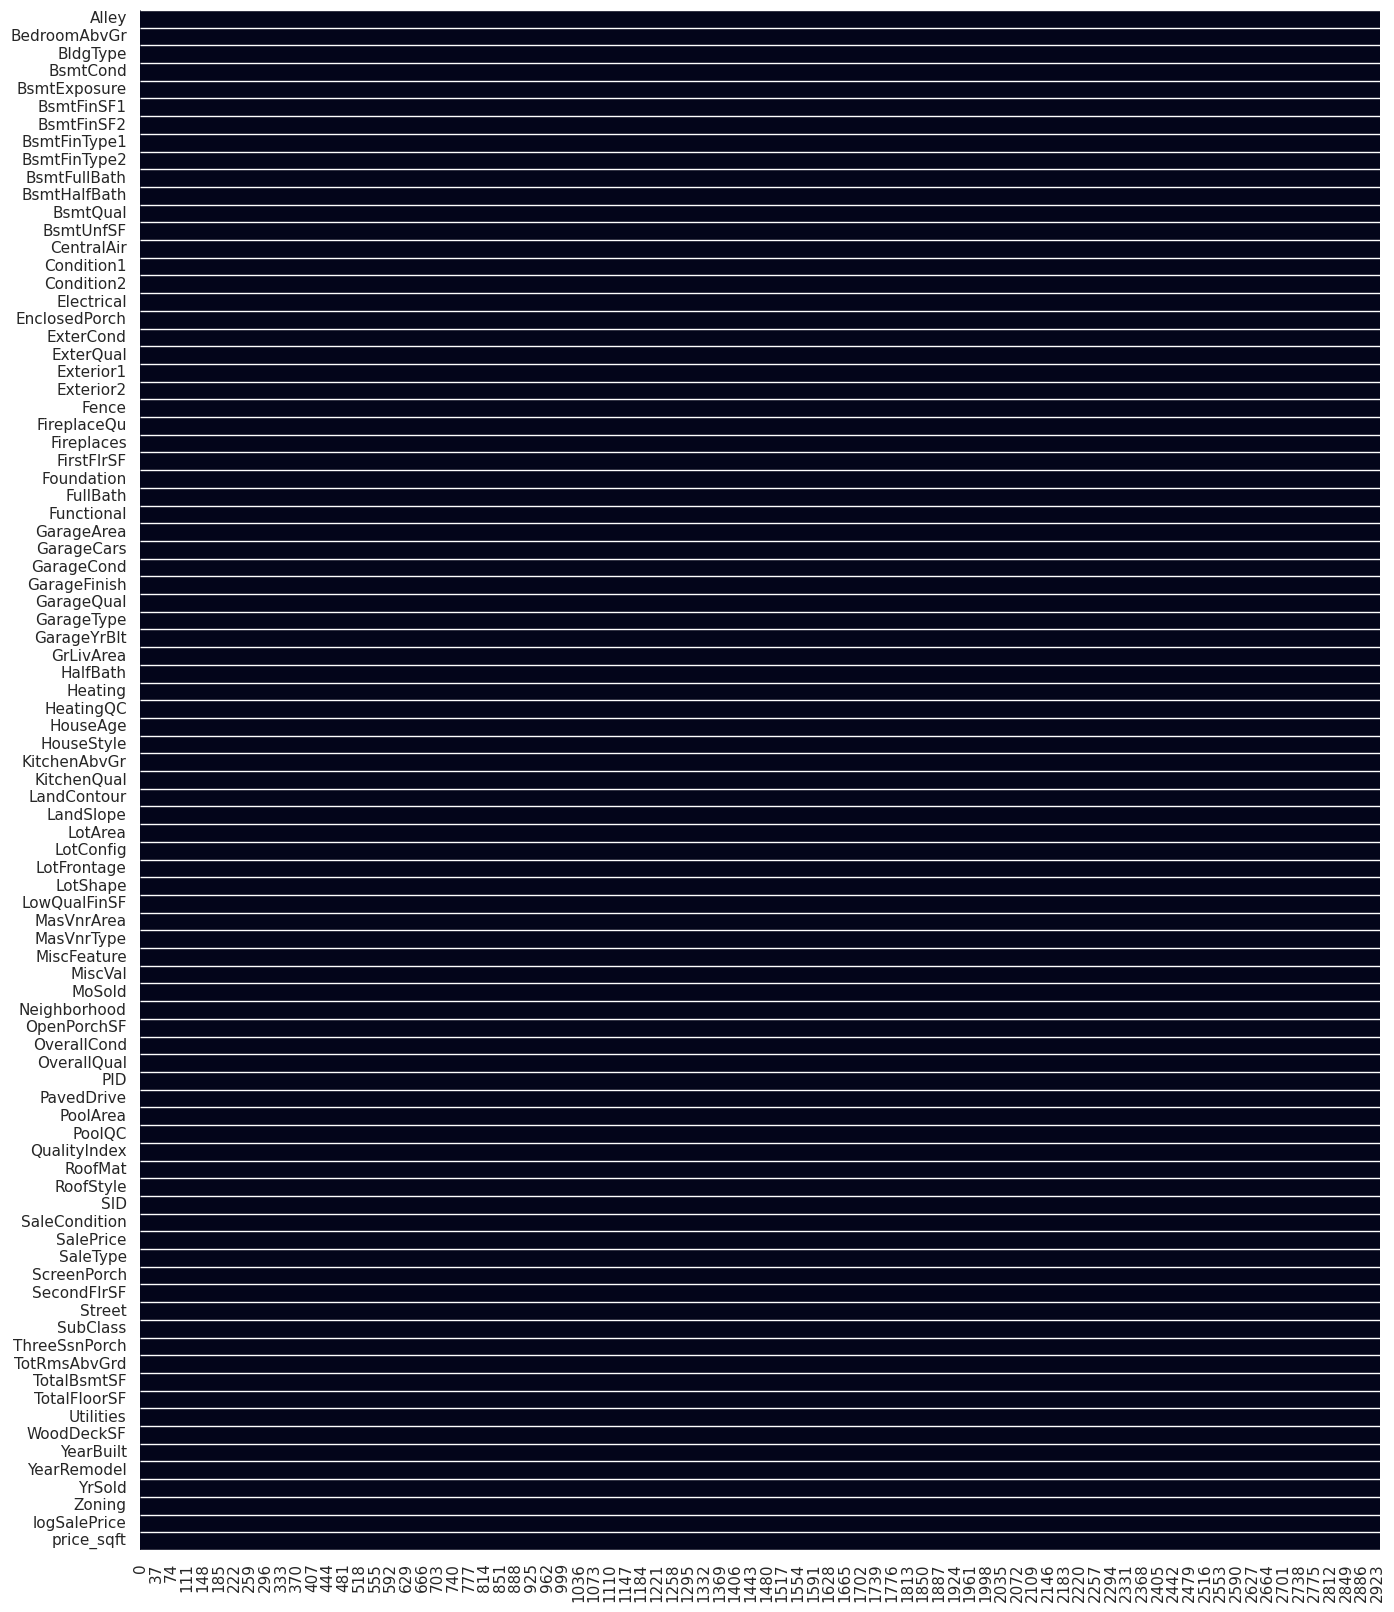

In [19]:
sns.set()
fig, ax1 = plt.subplots(figsize=(16, 20))

df_heat1=df.sort_index(axis=1, ascending=False)
sns.heatmap(df_heat1.T.isnull(), ax=ax1, cbar=False).invert_yaxis()
ax1.hlines(range(len(df_heat)), *ax1.get_xlim(), color='white', linewidths=1)
ax1.vlines([], [], [])
plt.yticks(rotation = 360)
plt.show()

# 3. A Data Quality Check

Even the most meticulously collected datasets can have issues with data quality, be it in the form of errors, outliers, or missing values. Beacuse of this, it is a fundamental step in any data analysis process to conduct a thorough data quality check.

If a data dictionary is available, it provides a valuable guide to what each field in the dataset should contain. Comparing the actual data against this dictionary can help identify inconsistencies and errors. However, even without a data dictionary, logical reasoning and exploratory analysis can assist in identifying and rectifying data quality issues.

For instance, in this project where we aim to model the sales price of houses, it's evident that a sales price of zero or negative doesn't make sense and should be considered an error.

Another example is handling outliers. If we have a small number of housing transactions with a sale price significantly higher than the majority, say over a million dollars, these could be valid but rare occurrences (outliers) or they could be errors. In either case, if our objective is to model 'typical' home prices, these high-value transactions may not be relevant and might skew our model.

Python libraries like pandas, numpy, and seaborn provide various functions that can be used to perform a data quality check. Let's select twenty variables from the dataset for this check. We'll use functions like describe(), value_counts(), isna().sum() for descriptive statistics, frequency counts, and null value check, respectively. Also, we'll use visualizations like histograms and box plots to check for outliers.

Based on the information below here is a comprehensive data quality check for each of our choosen variables:

<b>SalePrice:</b>      This is our target variable. The mean sale price of houses is around 180,796 dollars. The minimum sale price is 12,789 dollars, while the maximum is 755,000 dollars. There are no zero or negative sale prices, which is consistent with our expectations.

<b>OverallQual:</b>    This variable ranges from 1 to 10, with an average of around 6. There doesn't appear to be any data quality issues with this variable.

<b>GrLivArea:</b>      The average ground living area is approximately 1500 square feet. There are some houses with large ground living area values that could be considered outliers. We may need to investigate these further or handle them appropriately during modeling.

<b>GarageCars:</b>     This variable, indicating the size of the garage in car capacity, ranges from 0 to 5. The average garage size is around 1.76 cars.

<b>GarageArea:</b>     The average garage area is about 472 square feet. Similar to GrLivArea, there are some large values that may be outliers.

<b>GarageYrBlt:</b>    This variable seems to have missing data, denoted as "None". We'll need to decide how to handle these missing values, perhaps by filling in with an appropriate value or removing these records.

<b>MasVnrArea:</b>        The average area of masonry veneer is around 101 square feet, but half of the houses don't have masonry veneer (median and 25th percentile is zero). There are a few large values that may be considered outliers.

<b>Fireplaces:</b>        The majority of the houses have either one or no fireplaces. However, there are some houses with up to four fireplaces.

<b>BsmtFinSF1:</b>        The average finished square feet of the basement area is around 442. However, many houses do not have a finished basement area (indicated by zero values).

<b>LotFrontage:</b>       The average linear feet of street connected to the property is around 69 feet. There are some properties with exceptionally large frontage.

<b>TotalBsmtSF:</b>       This variable represents the total square feet of the basement area. The average is about 1051 square feet. Similar to GrLivArea, it appears that there are some outliers present with an exceptionally large basement area.

<b>FirstFlrSF:</b>        This variable represents the First Floor square feet. The average is around 1159 square feet. The data range from 334 to 5095 square feet, suggesting a wide range of house sizes.

<b>FullBath:</b>          The average number of full bathrooms is approximately 1.57. The values range from 0 to 4. This variable does not seem to have any anomalies or outliers.

<b>TotRmsAbvGrd:</b>      This variable represents the total rooms above grade (does not include bathrooms). The average number is around 6.44, and the range is from 2 to 15. There don't appear to be any data quality issues with this variable.

<b>YearBuilt:</b>         This variable indicates the original construction date. The average year of construction is around 1971. It ranges from 1872 to 2010. There doesn't appear to be any data quality issues with this variable.

<b>LotFrontage:</b>       This variable measures the Linear feet of street connected to the property. The average lot frontage is around 69 feet, but some houses have as much as 313 feet of street connected to the property.

<b>WoodDeckSF:</b>        This variable measures the wood deck area in square feet. On average, houses have around 94 square feet of wood deck area. However, many houses don't have a wood deck at all (indicated by the median and 25th percentile being zero), while some have very large wood decks.

<b>SecondFlrSF:</b>       This variable measures the second floor area in square feet. On average, houses have around 335 square feet of the second-floor area. However, many houses don't have a second floor at all (indicated by the median and 25th percentile being zero), while some have a very large second floor.

<b>OpenPorchSF:</b>       This variable measures the open porch area in square feet. The average open porch area is around 48 square feet. However, many houses don't have an open porch (indicated by the median and 25th percentile being zero), while some have a very large open porch.

<b>HalfBath:</b>          The average number of half bathrooms is around 0.38, indicating that many houses do not have a half bathroom. The variable ranges from 0 to 2, and there doesn't seem to be any anomalies or outliers.

In [20]:
variables_to_check = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 
                      'TotalBsmtSF', 'FirstFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt', 
                      'GarageYrBlt', 'MasVnrArea', 'Fireplaces', 
                      'BsmtFinSF1', 'LotFrontage', 'WoodDeckSF', 'SecondFlrSF', 
                      'OpenPorchSF', 'HalfBath']

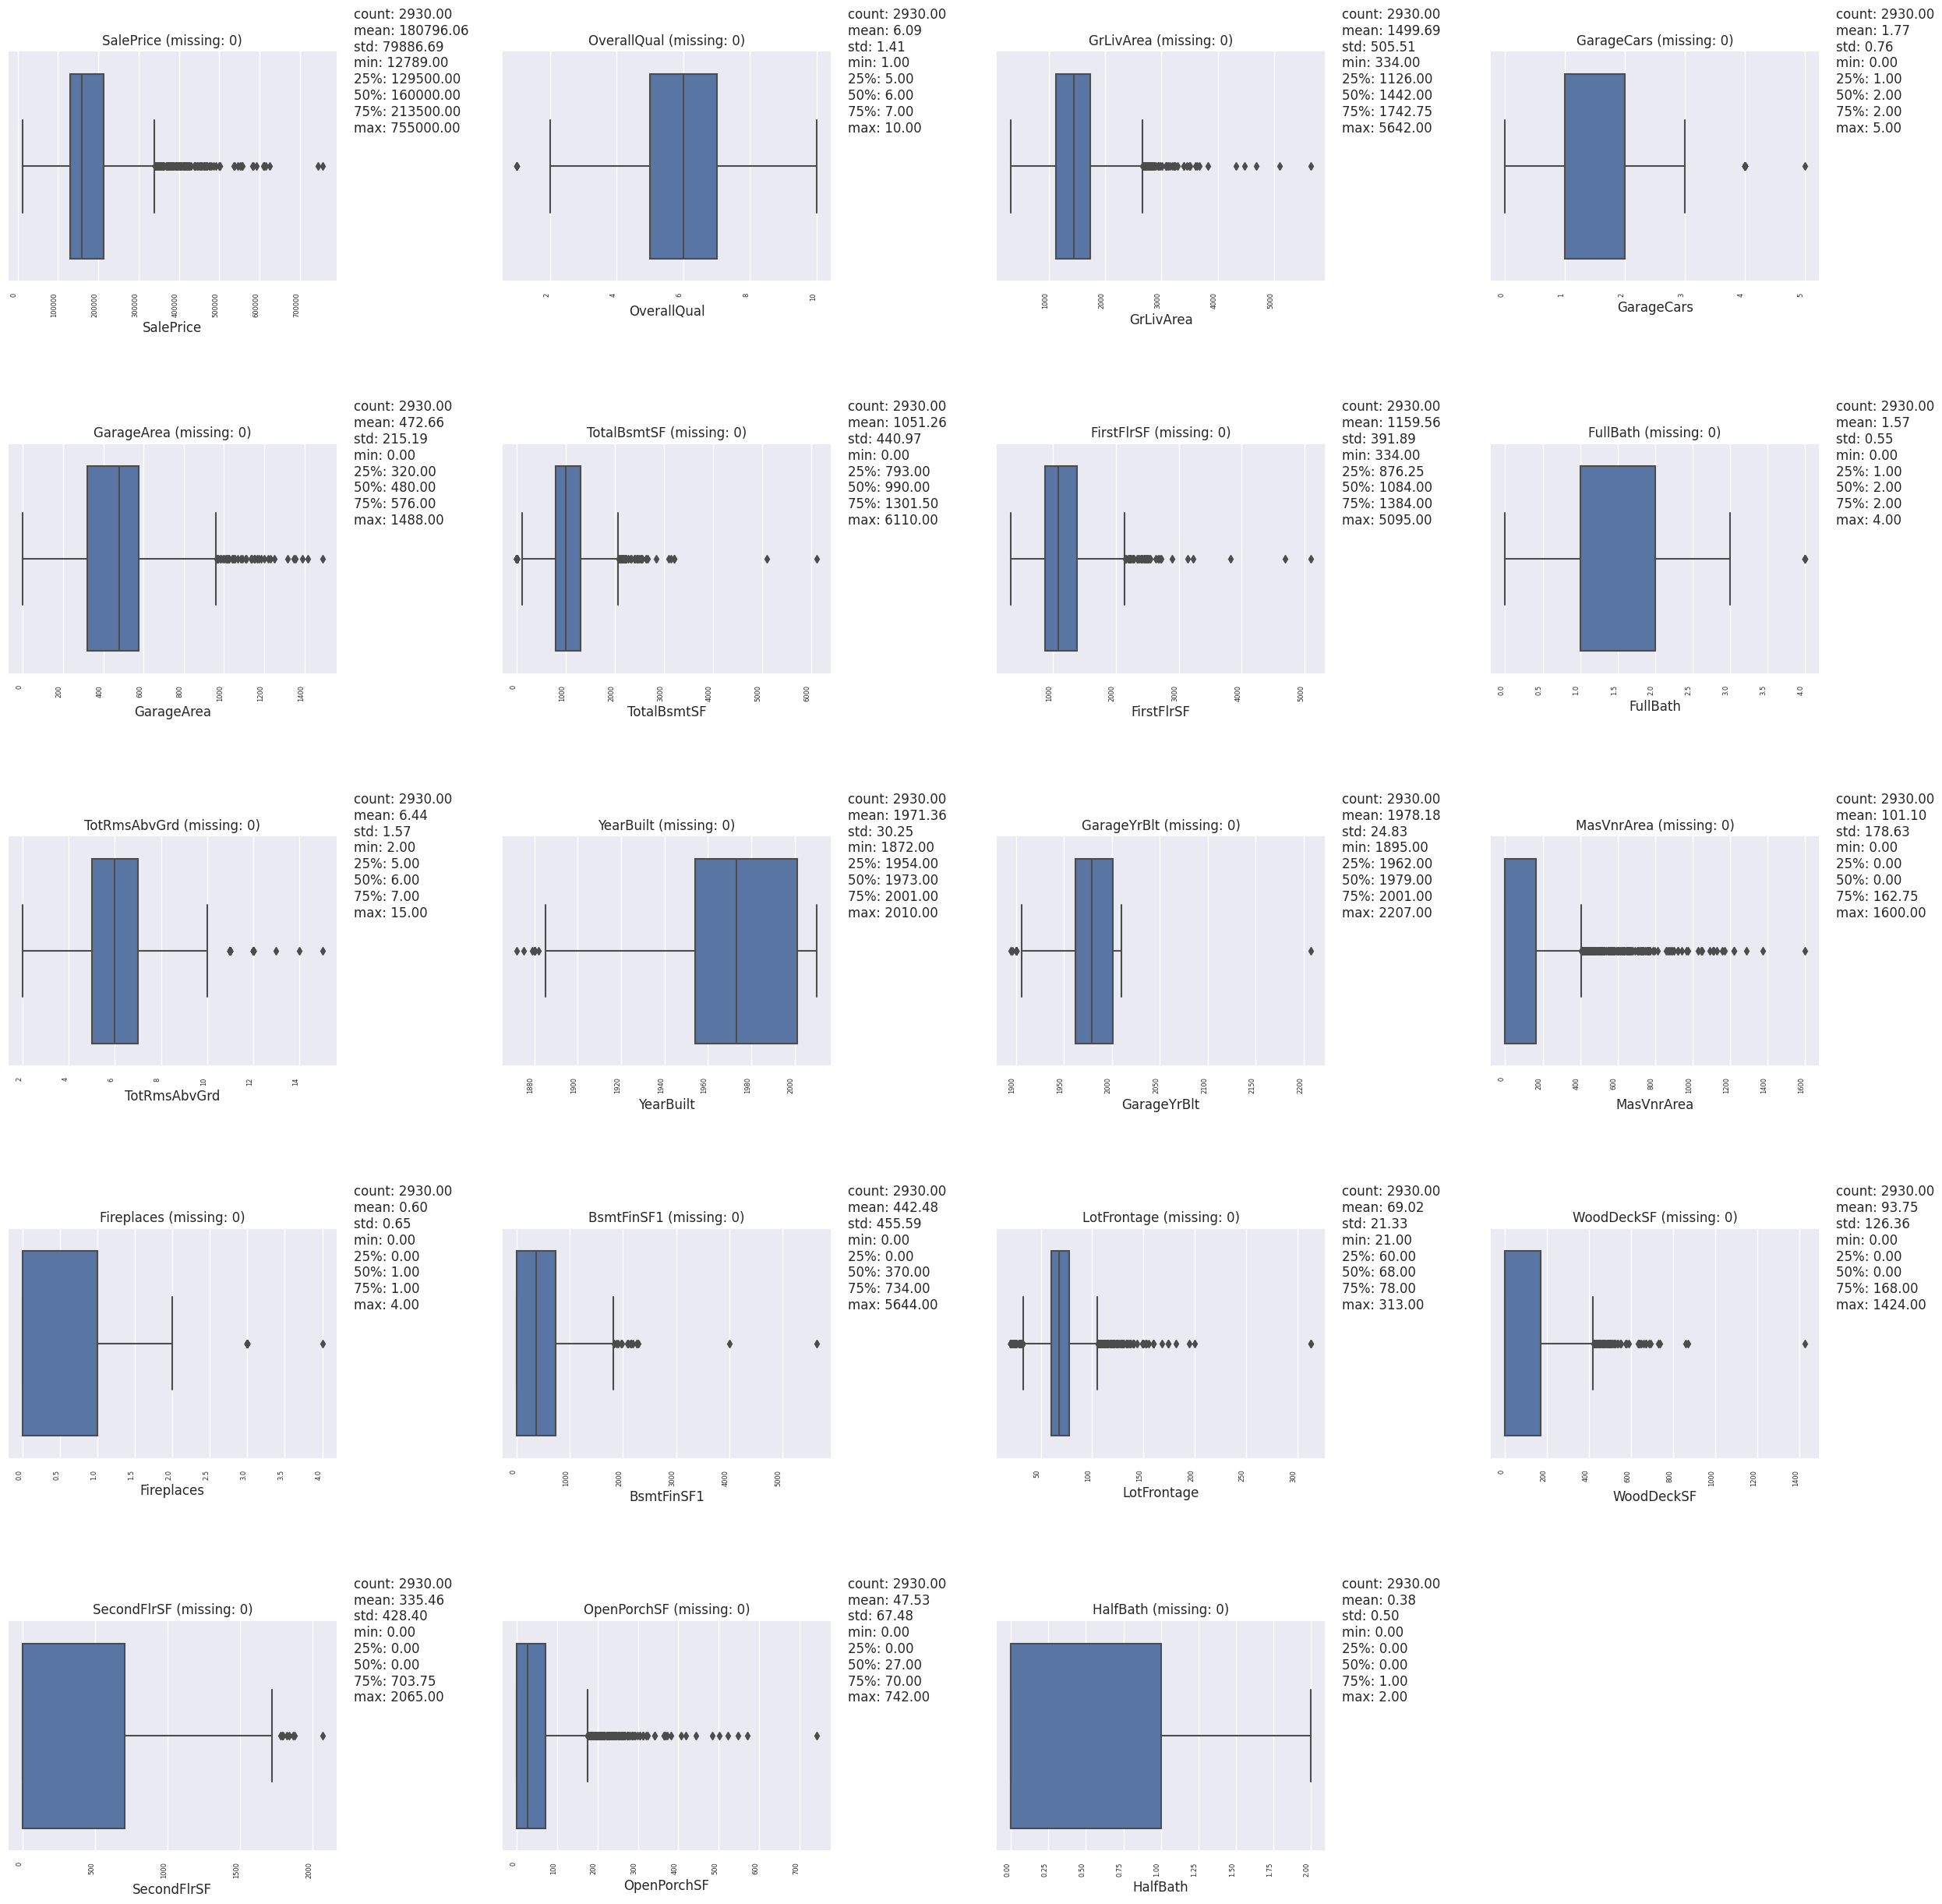

In [21]:
fig, axs = plt.subplots(5, 4, figsize=(30, 30))
axs = axs.ravel()
df['GarageYrBlt']=round(df['GarageYrBlt'].astype(float),0)
for i, var in enumerate(variables_to_check):
    if df[var].dtype in ['int64', 'float64']:  
        summary_stats = df[var].describe()
        sns.boxplot(x=df[var], ax=axs[i])

        axs[i].set_title(f'{var} (missing: {df[var].isna().sum()})')
        stats_text = "\n".join([f'{stat}: {value:.2f}' for stat, value in summary_stats.items()])
        axs[i].annotate(stats_text, xy=(1.05, .65), xycoords=axs[i].transAxes)

    else:  
        sns.countplot(x=df[var].dropna(), ax=axs[i])
        axs[i].set_title(f'{var} (missing: {df[var].isna().sum()})')

    for label in axs[i].get_xticklabels():
        label.set_rotation(90)
        label.set_horizontalalignment('right')
        label.set_fontsize(6)

for i in range(len(variables_to_check), 20):
    fig.delaxes(axs[i])

plt.subplots_adjust(wspace=0.5, hspace=0.7)
plt.show()


In [23]:
### Everything looks right to me but the year built has one odd value. I am going to fill it with the median. 

df['GarageYrBlt']=df['GarageYrBlt'].replace(df['GarageYrBlt'].max(), df['GarageYrBlt'].median())
df['GarageYrBlt'].describe()

count    2930.000000
mean     1978.101706
std        24.463835
min      1895.000000
25%      1962.000000
50%      1979.000000
75%      2001.000000
max      2010.000000
Name: GarageYrBlt, dtype: float64

# 4. An Initial Exploratory Data Analysis

I will be choosing the following variables:

<strong>Continuous Variables:</strong> <br>
<br>
<b>LotFrontage:</b> The scatterplot of 'SalePrice' and 'LotFrontage' shows a positive correlation. Properties with a larger street connected to their lot seem to fetch higher prices. The boxplot shows a few outliers, with some properties having unusually large frontages.

<b>LotArea:</b> This variable also indicates a positive correlation with 'SalePrice', indicating larger properties tend to have higher prices. The boxplot for 'LotArea' also reveals the presence of several outliers.

<b>FirstFlrSF:</b> First floor square feet, again, shows a positive correlation with 'SalePrice'. Houses with larger first floors are more expensive. The boxplot shows a few properties with unusually large first-floor areas.

<b>GrLivArea:</b> Above grade (ground) living area square feet shows a strong positive correlation with 'SalePrice'. The larger the living area, the higher the property's price. Outliers are present but fewer compared to other variables.

<b>GarageArea:</b> This variable too exhibits a positive correlation with 'SalePrice'. Houses with larger garage areas demand higher prices. There are a few outliers as seen in the boxplot.
<br>
<br>
<br>
<strong>Discrete or Categorical Variables:</strong> <br>
<br>

<b>YearBuilt:</b> The year in which the property was built can have a significant impact on its sale price. Generally, newer houses tend to command higher prices. The boxplot of 'SalePrice' for each year reveals that some years have a higher median sale price compared to others, indicating the influence of the year of construction on the property's value.

<b>OverallQual:</b> The overall quality shows a strong correlation with 'SalePrice'. Properties with better overall quality score higher prices.

<b>OverallCond:</b> While one might expect a significant impact of overall condition on 'SalePrice', it seems to have a more nuanced relationship with price.

<b>BsmtFullBath:</b> Properties with more full bathrooms in the basement are likely to fetch higher prices. However, there's significant variation within each category.

<b>GarageCars:</b> The capacity of the garage (in car capacity) significantly influences the 'SalePrice'. Properties with larger garages (in terms of car capacity) have higher prices.

For all boxplots of categorical variables, we observe a trend where certain categories have a higher median sale price, indicative of their impact on the house pricing.

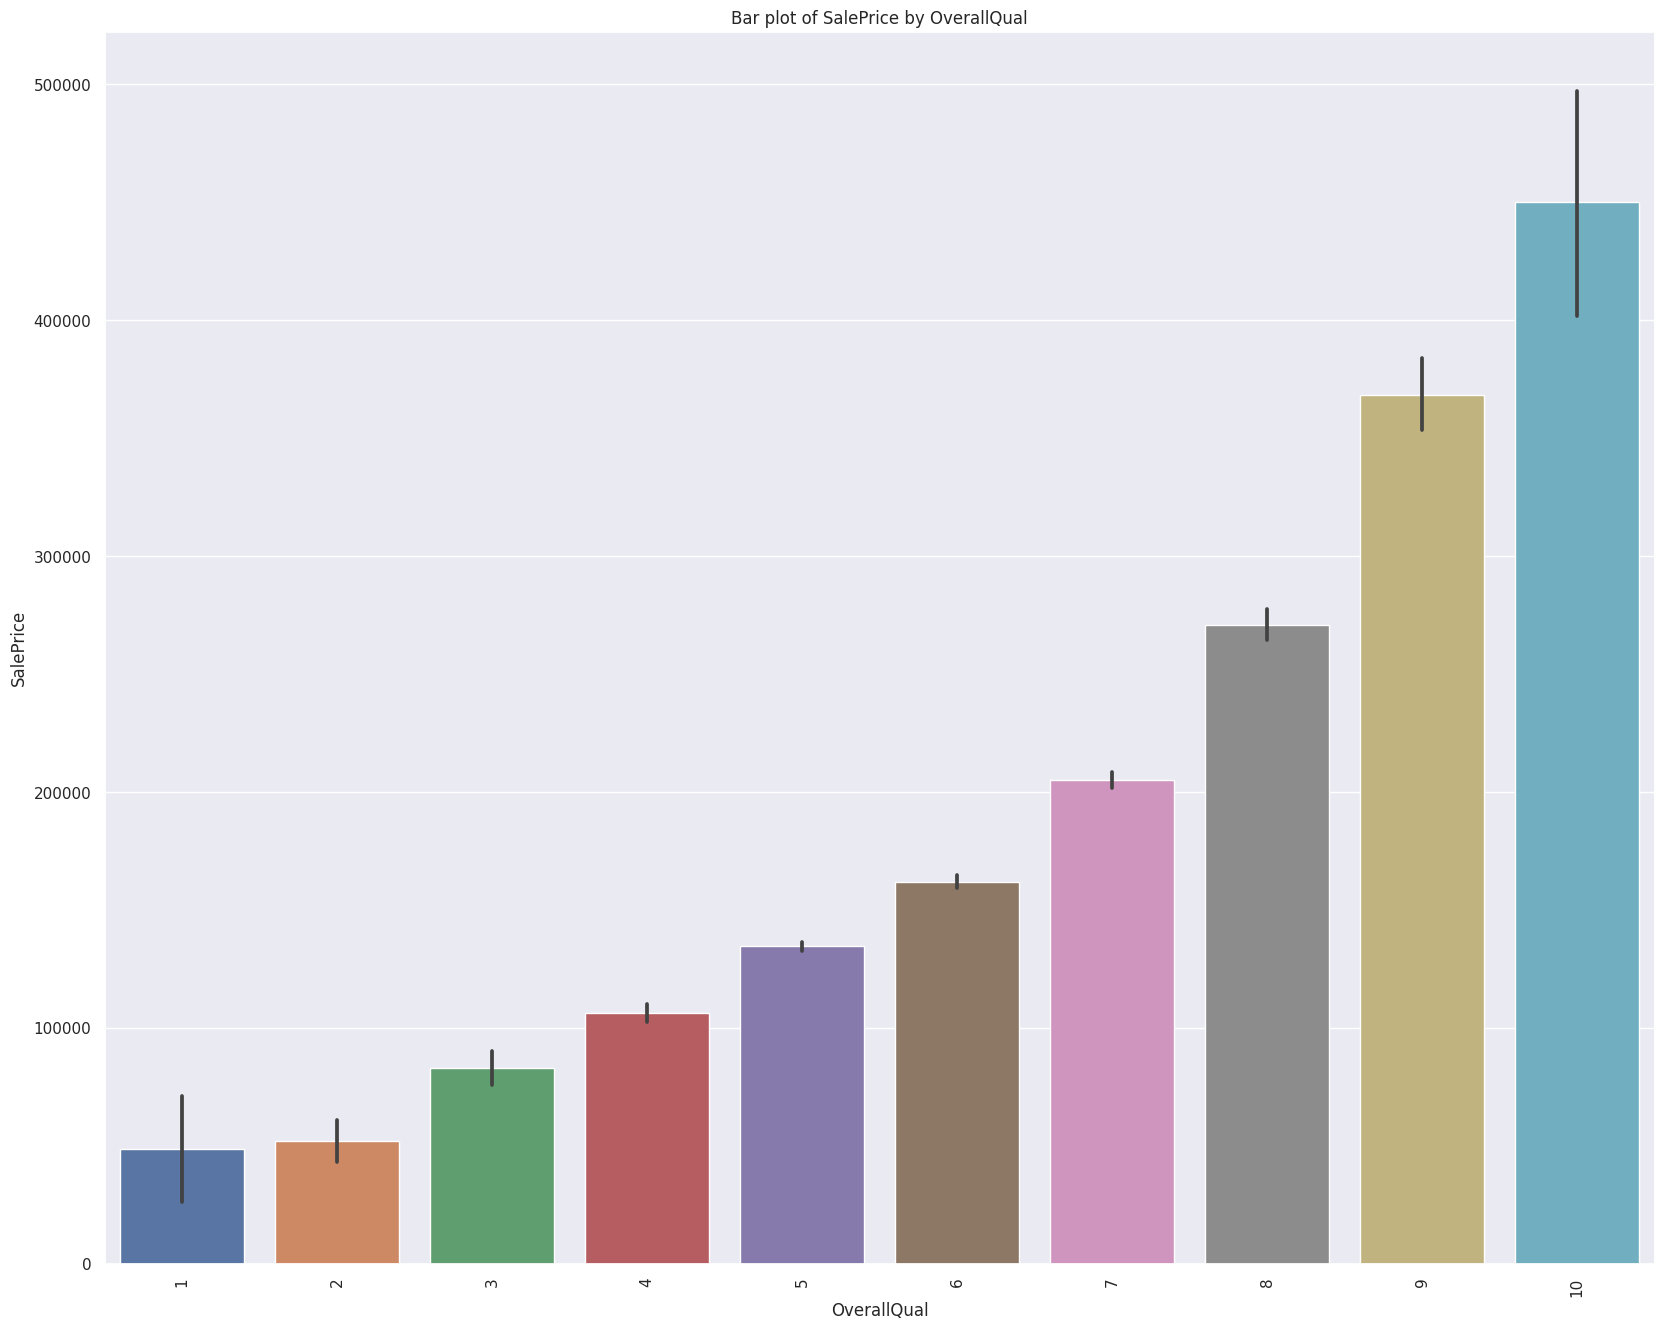

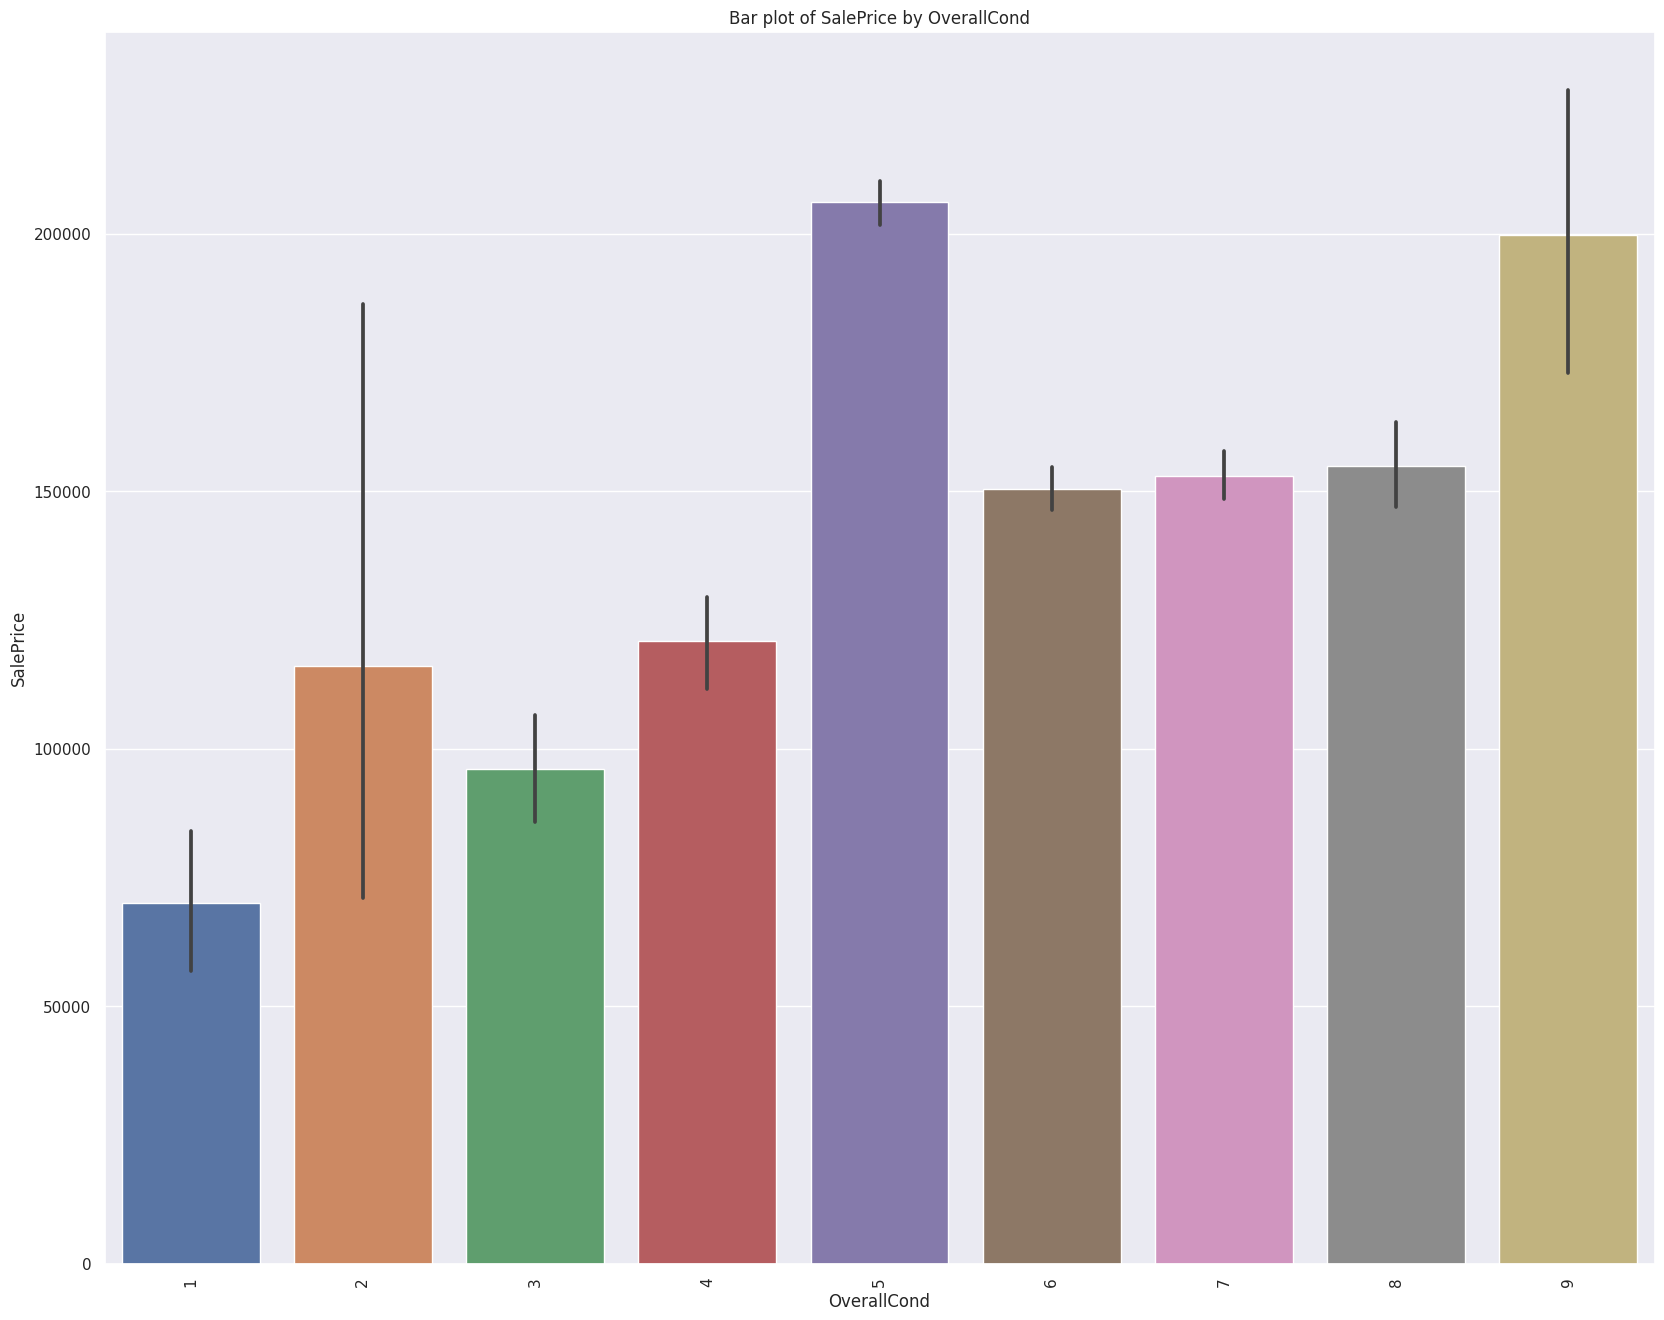

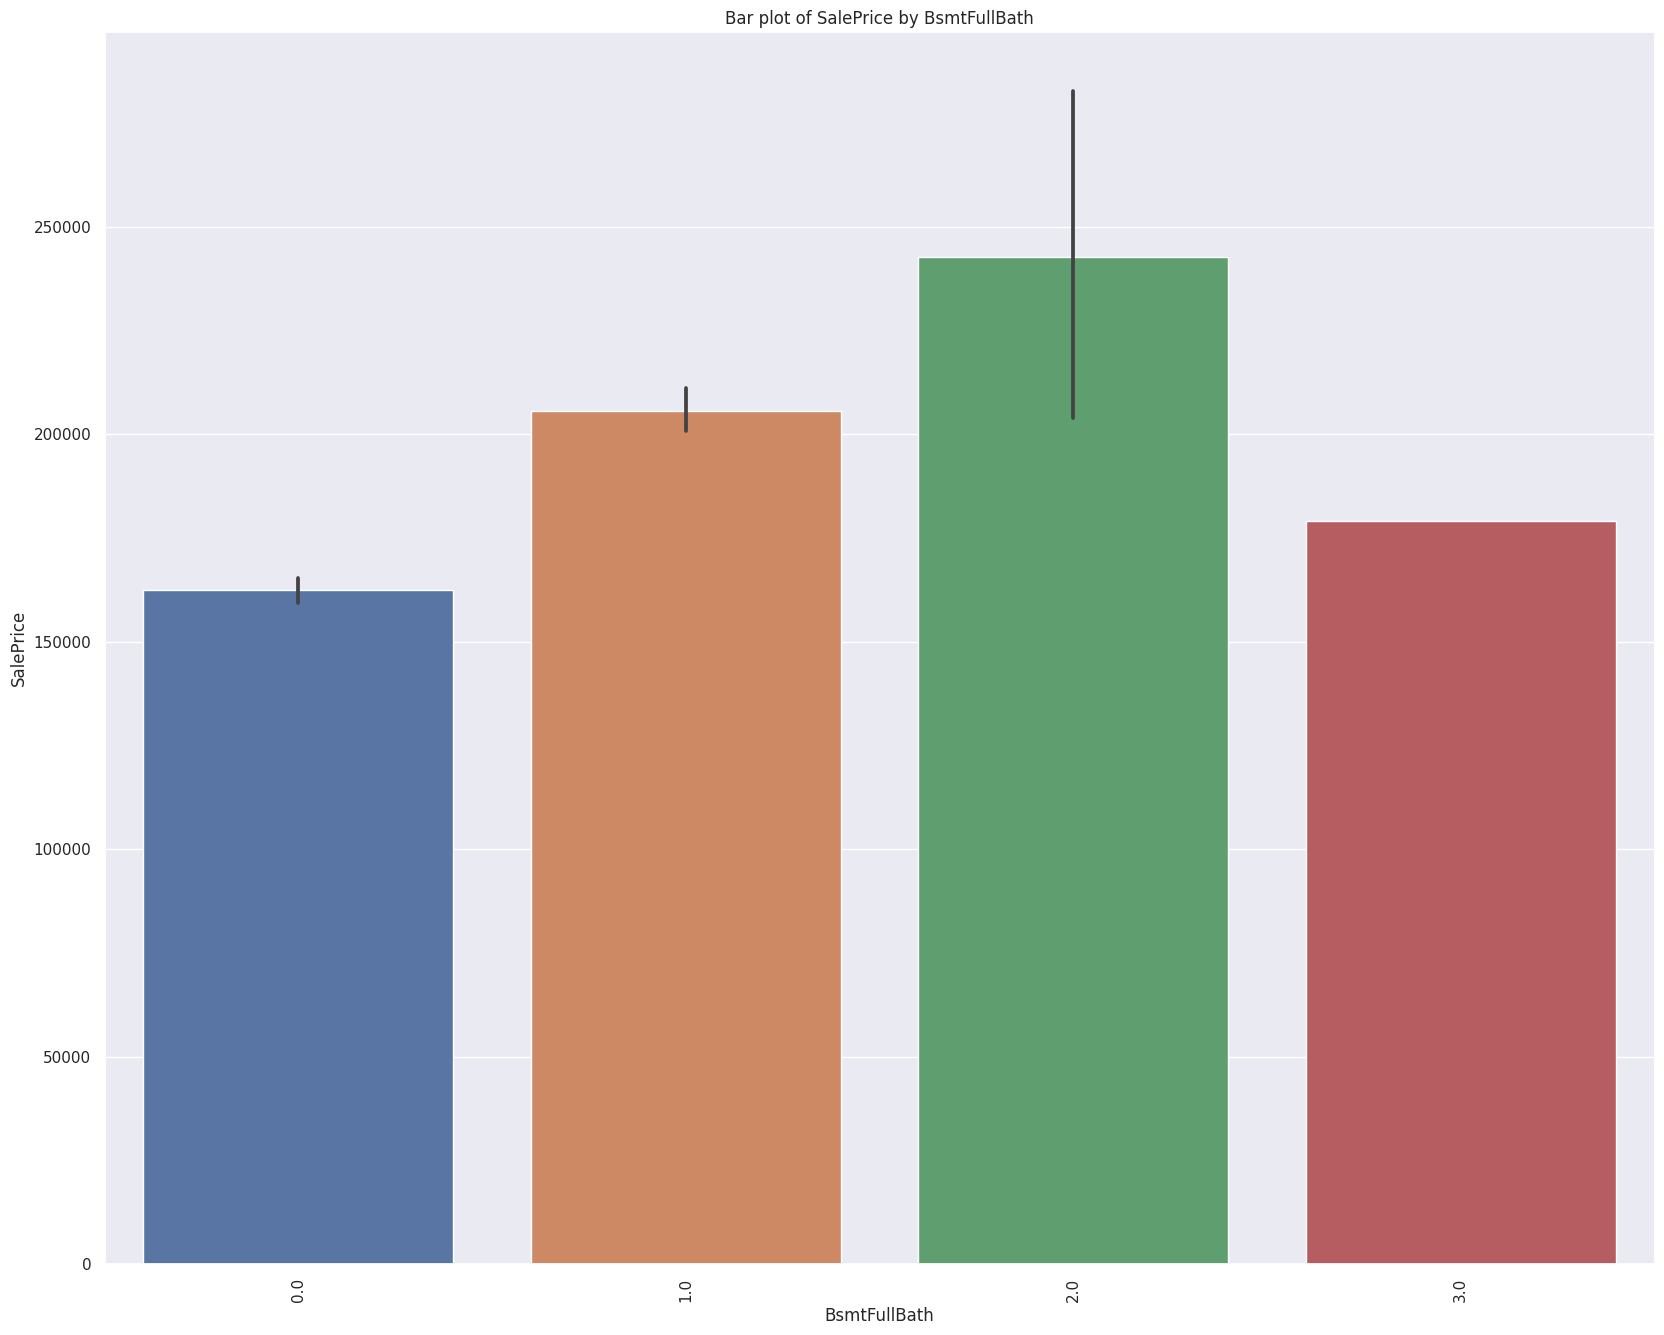

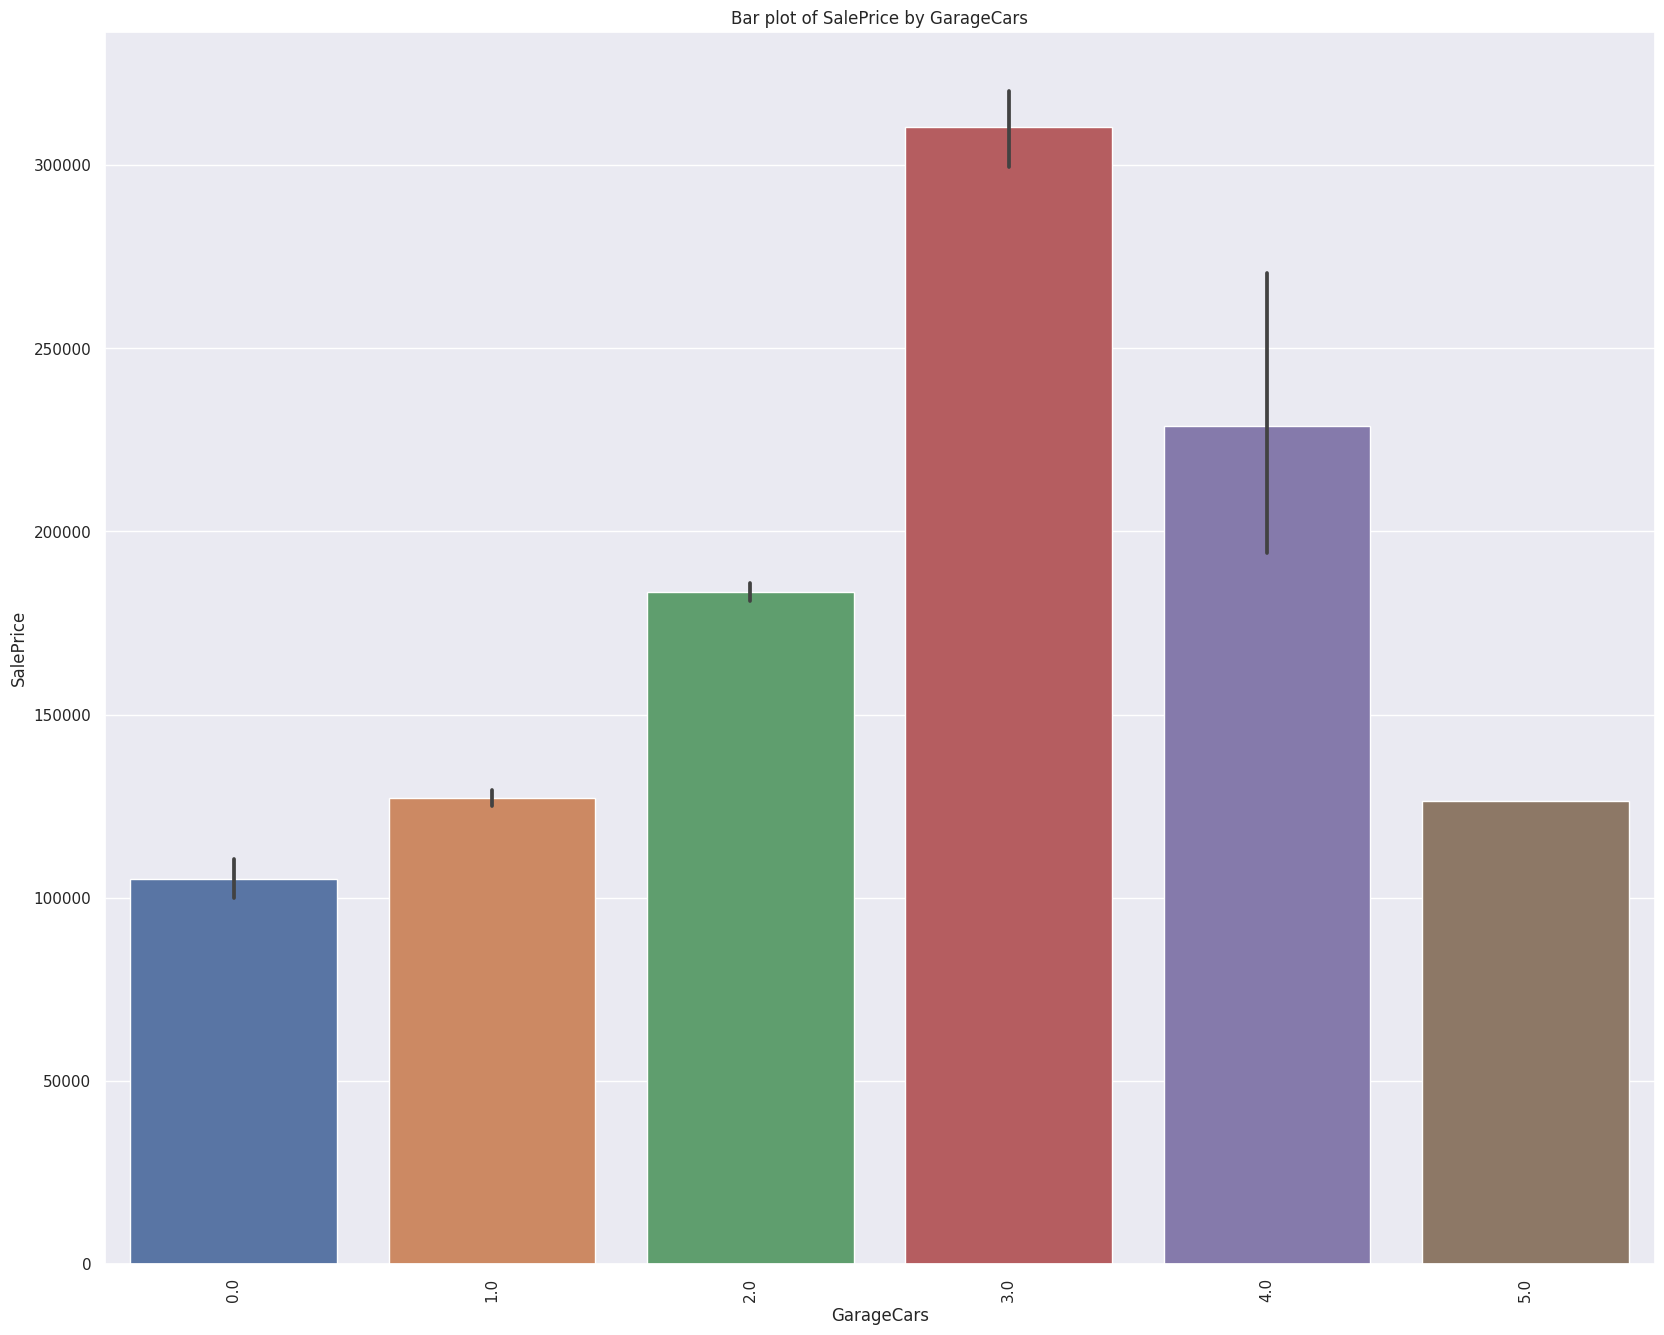

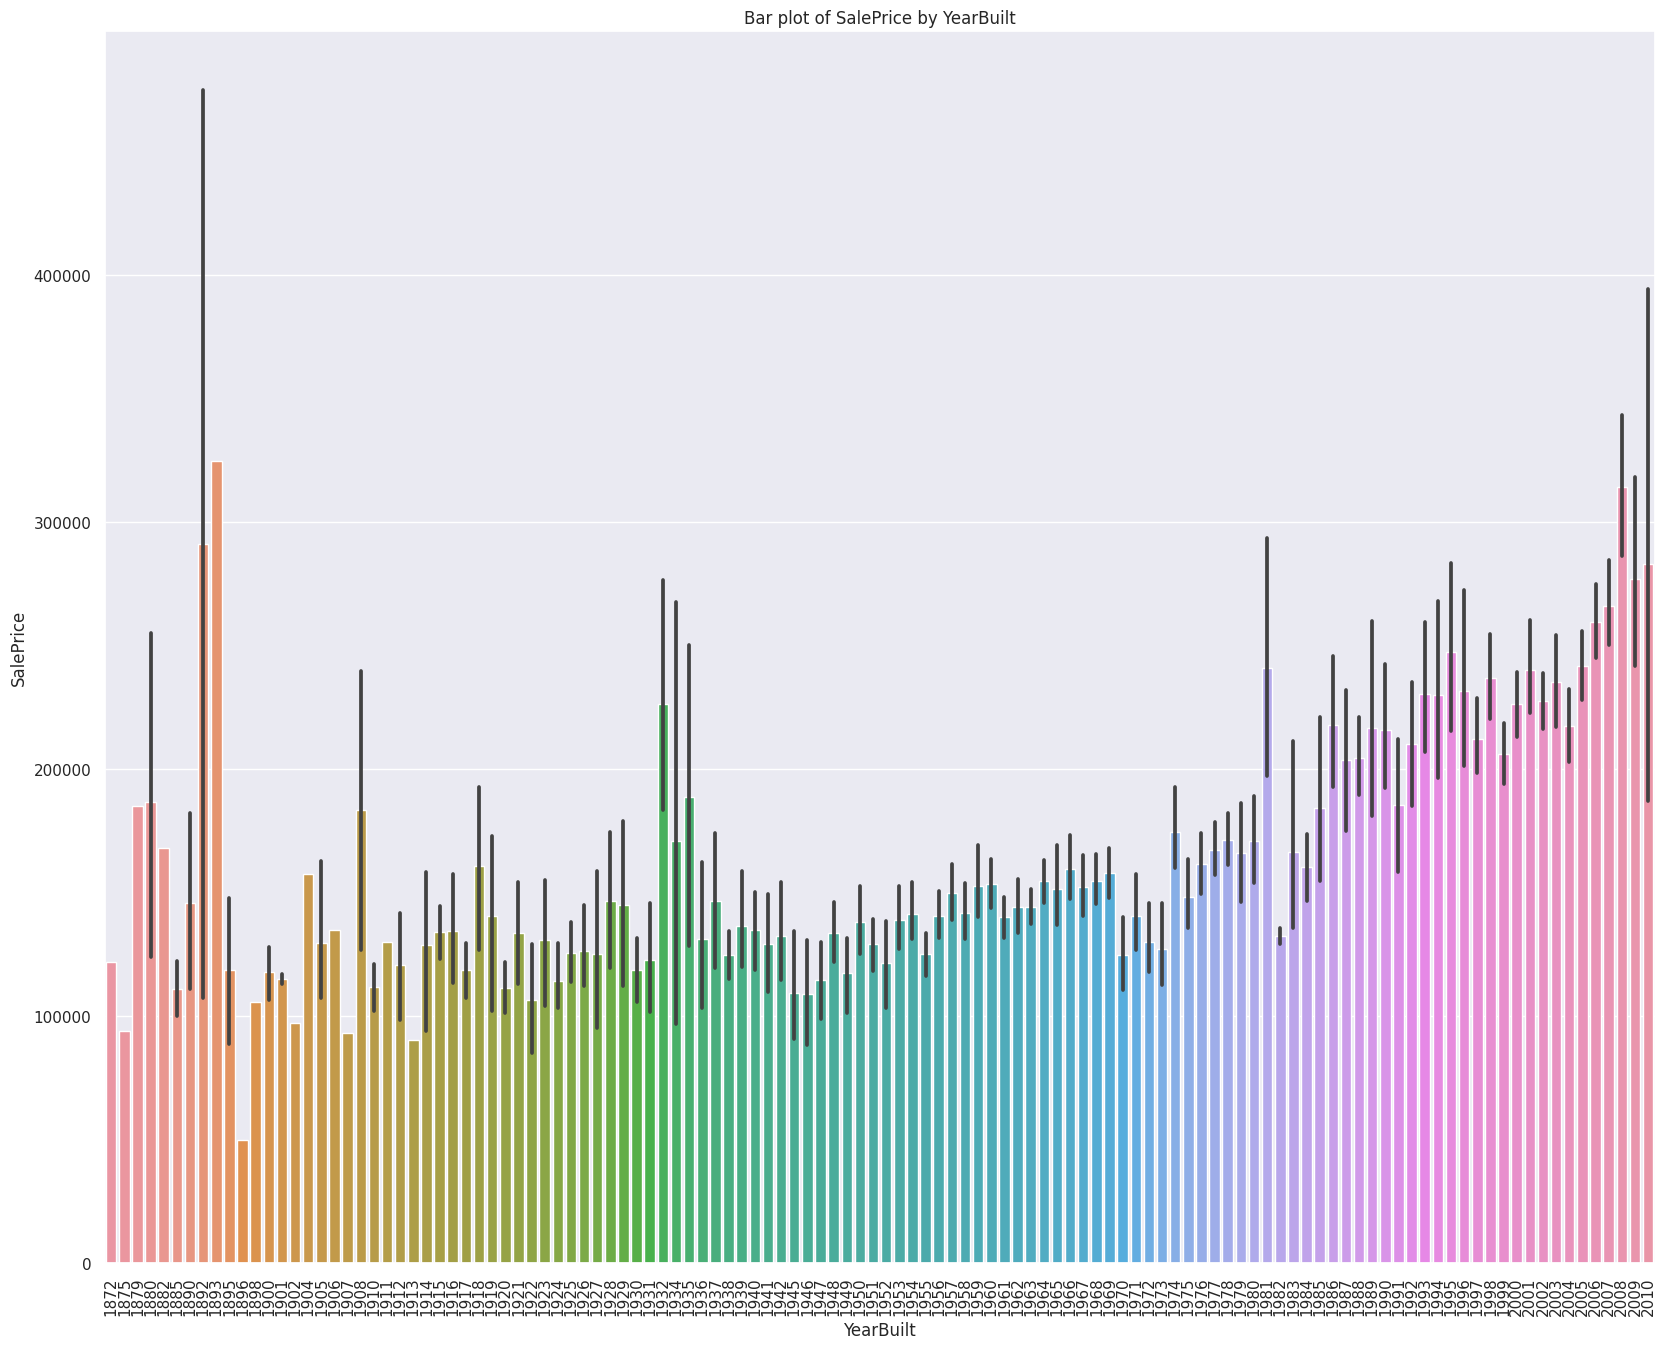

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

categorical_vars = ['OverallQual', 'OverallCond', 'BsmtFullBath', 'GarageCars', 'YearBuilt']

for var in categorical_vars:
    plt.figure(figsize=(20, 16))
    sns.barplot(x=var, y='SalePrice', data=df)
    plt.title(f'Bar plot of SalePrice by {var}')
    plt.ylabel('SalePrice')
    plt.xlabel(var)
    plt.xticks(rotation=90)
    plt.show()

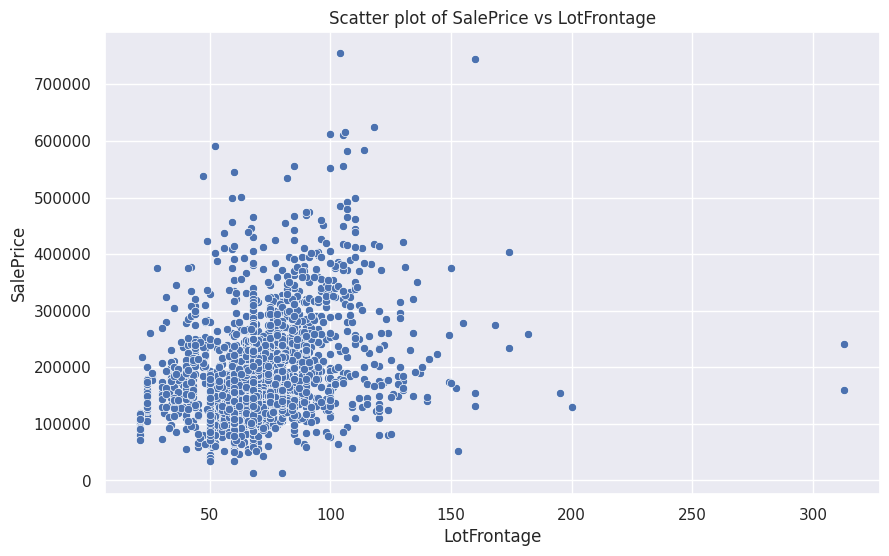

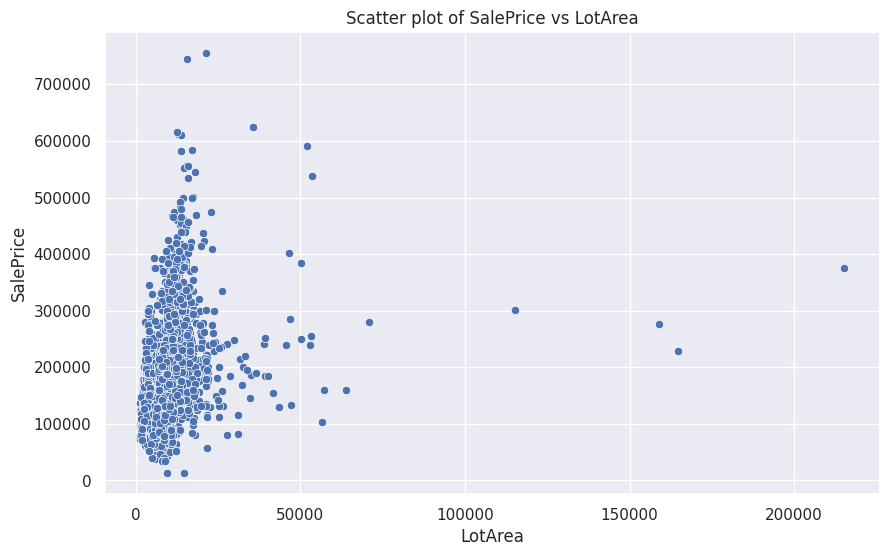

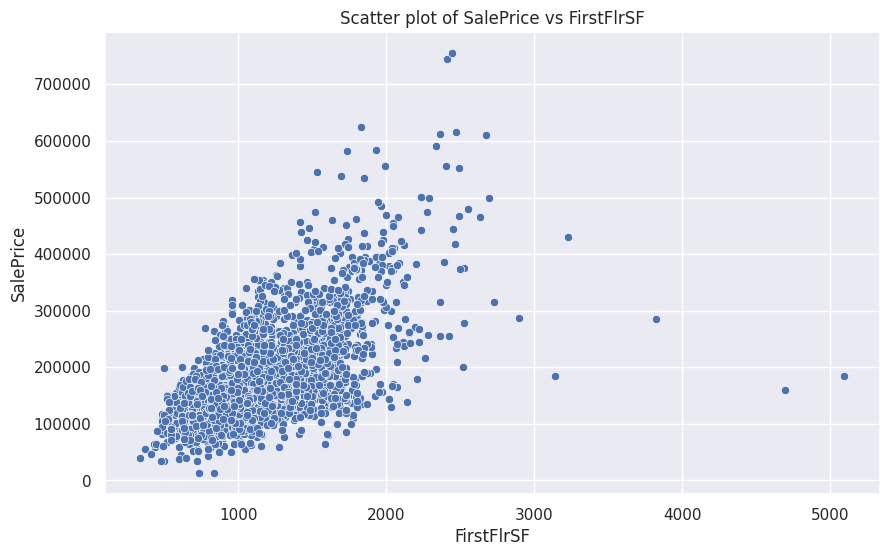

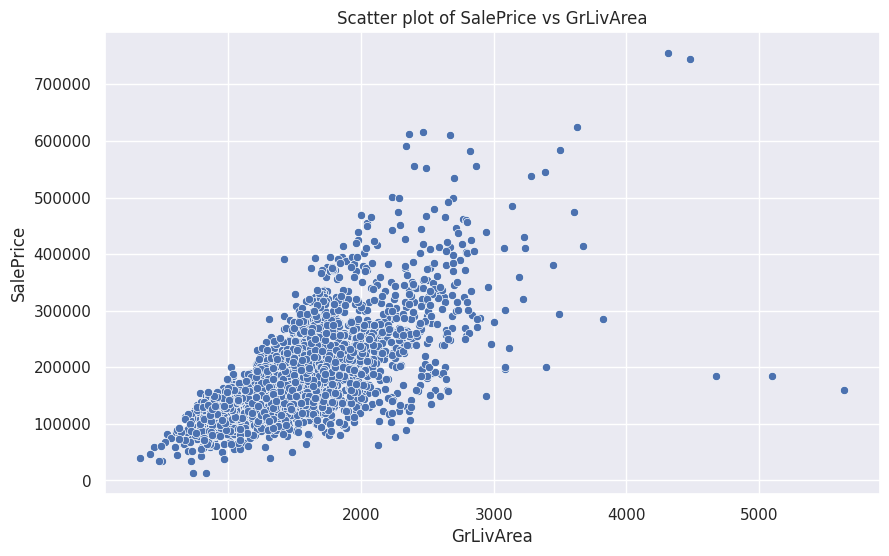

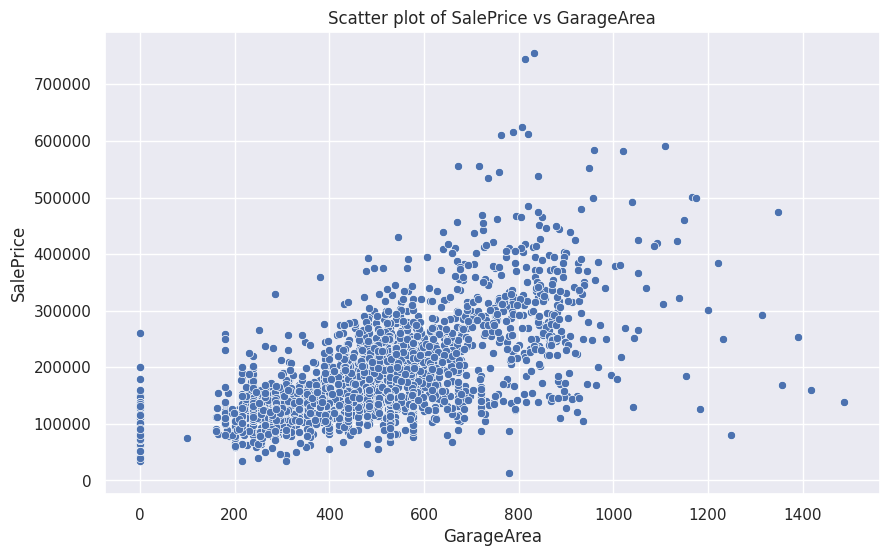

In [35]:
continuous_vars = ['LotFrontage', 'LotArea', 'FirstFlrSF', 'GrLivArea', 'GarageArea']

for var in continuous_vars:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=var, y='SalePrice', data=df)
    plt.title(f'Scatter plot of SalePrice vs {var}')
    plt.xlabel(var)
    plt.ylabel('SalePrice')
    plt.show()


# 5. An Initial Exporlatory Data Analysis for Modeling

The response variable in this problem is the SalePrice, which represents the sale price of houses. It is a continuous variable that we aim to predict using regression models.

In addition to the raw SalePrice variable, it is worth considering a transformation of the response variable. One common transformation is taking the logarithm of the SalePrice (log(SalePrice)). This transformation can help address issues of non-linearity and heteroscedasticity in the relationship between the predictor variables and the SalePrice. By taking the logarithm, we can potentially achieve a more linear and normally distributed relationship, which is desirable for regression modeling.

From the initial exploratory data analysis, three variables that showed a notable relationship with SalePrice and log(SalePrice) are OverallQual, GrLivArea, and GarageCars. These variables exhibited clear patterns and correlations with the SalePrice, indicating their potential importance in predicting house prices.

The EDA suggests some potential difficulties or concerns for the model building process. Firstly, there are some outliers present in the relationship between the predictor variables and the SalePrice. These outliers may impact the model's performance and could require further investigation and potential removal. Additionally, there are instances where the relationship between the predictor variables and the SalePrice is non-linear, indicating the need to consider nonlinear modeling techniques or transformations.

Furthermore, the EDA suggests that there may be a need to consider transformations in the predictor variables during the model building process. For example, variables such as GrLivArea and GarageCars exhibited skewed distributions, which might benefit from transformation to improve linearity and distributional assumptions.

Overall, the EDA provides valuable insights into the relationships between the selected variables and the SalePrice. It highlights potential challenges, such as outliers and non-linear relationships, which should be addressed during the model building process. Additionally, it suggests considering transformations for both the response variable and the predictor variables to improve the model's performance and meet the assumptions of linear regression.

### Converted EDA Starter Code

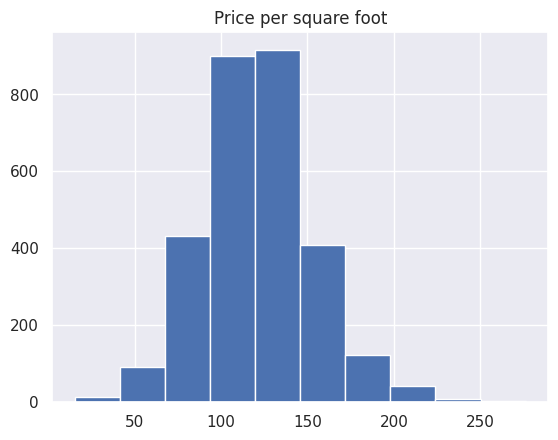

In [22]:
plt.hist(df['price_sqft'])
plt.title('Price per square foot')
plt.show()

In [23]:
subdat = df[["TotalFloorSF", "HouseAge", "QualityIndex", "price_sqft", 
                 "SalePrice", "LotArea", "BsmtFinSF1", "Neighborhood", 
                 "HouseStyle", "LotShape", "OverallQual", "logSalePrice", 
                 "TotalBsmtSF", "HouseStyle"]]
subdatnum = df[["TotalFloorSF", "HouseAge", "QualityIndex", 
                    "SalePrice", "LotArea", "OverallQual", "logSalePrice"]]

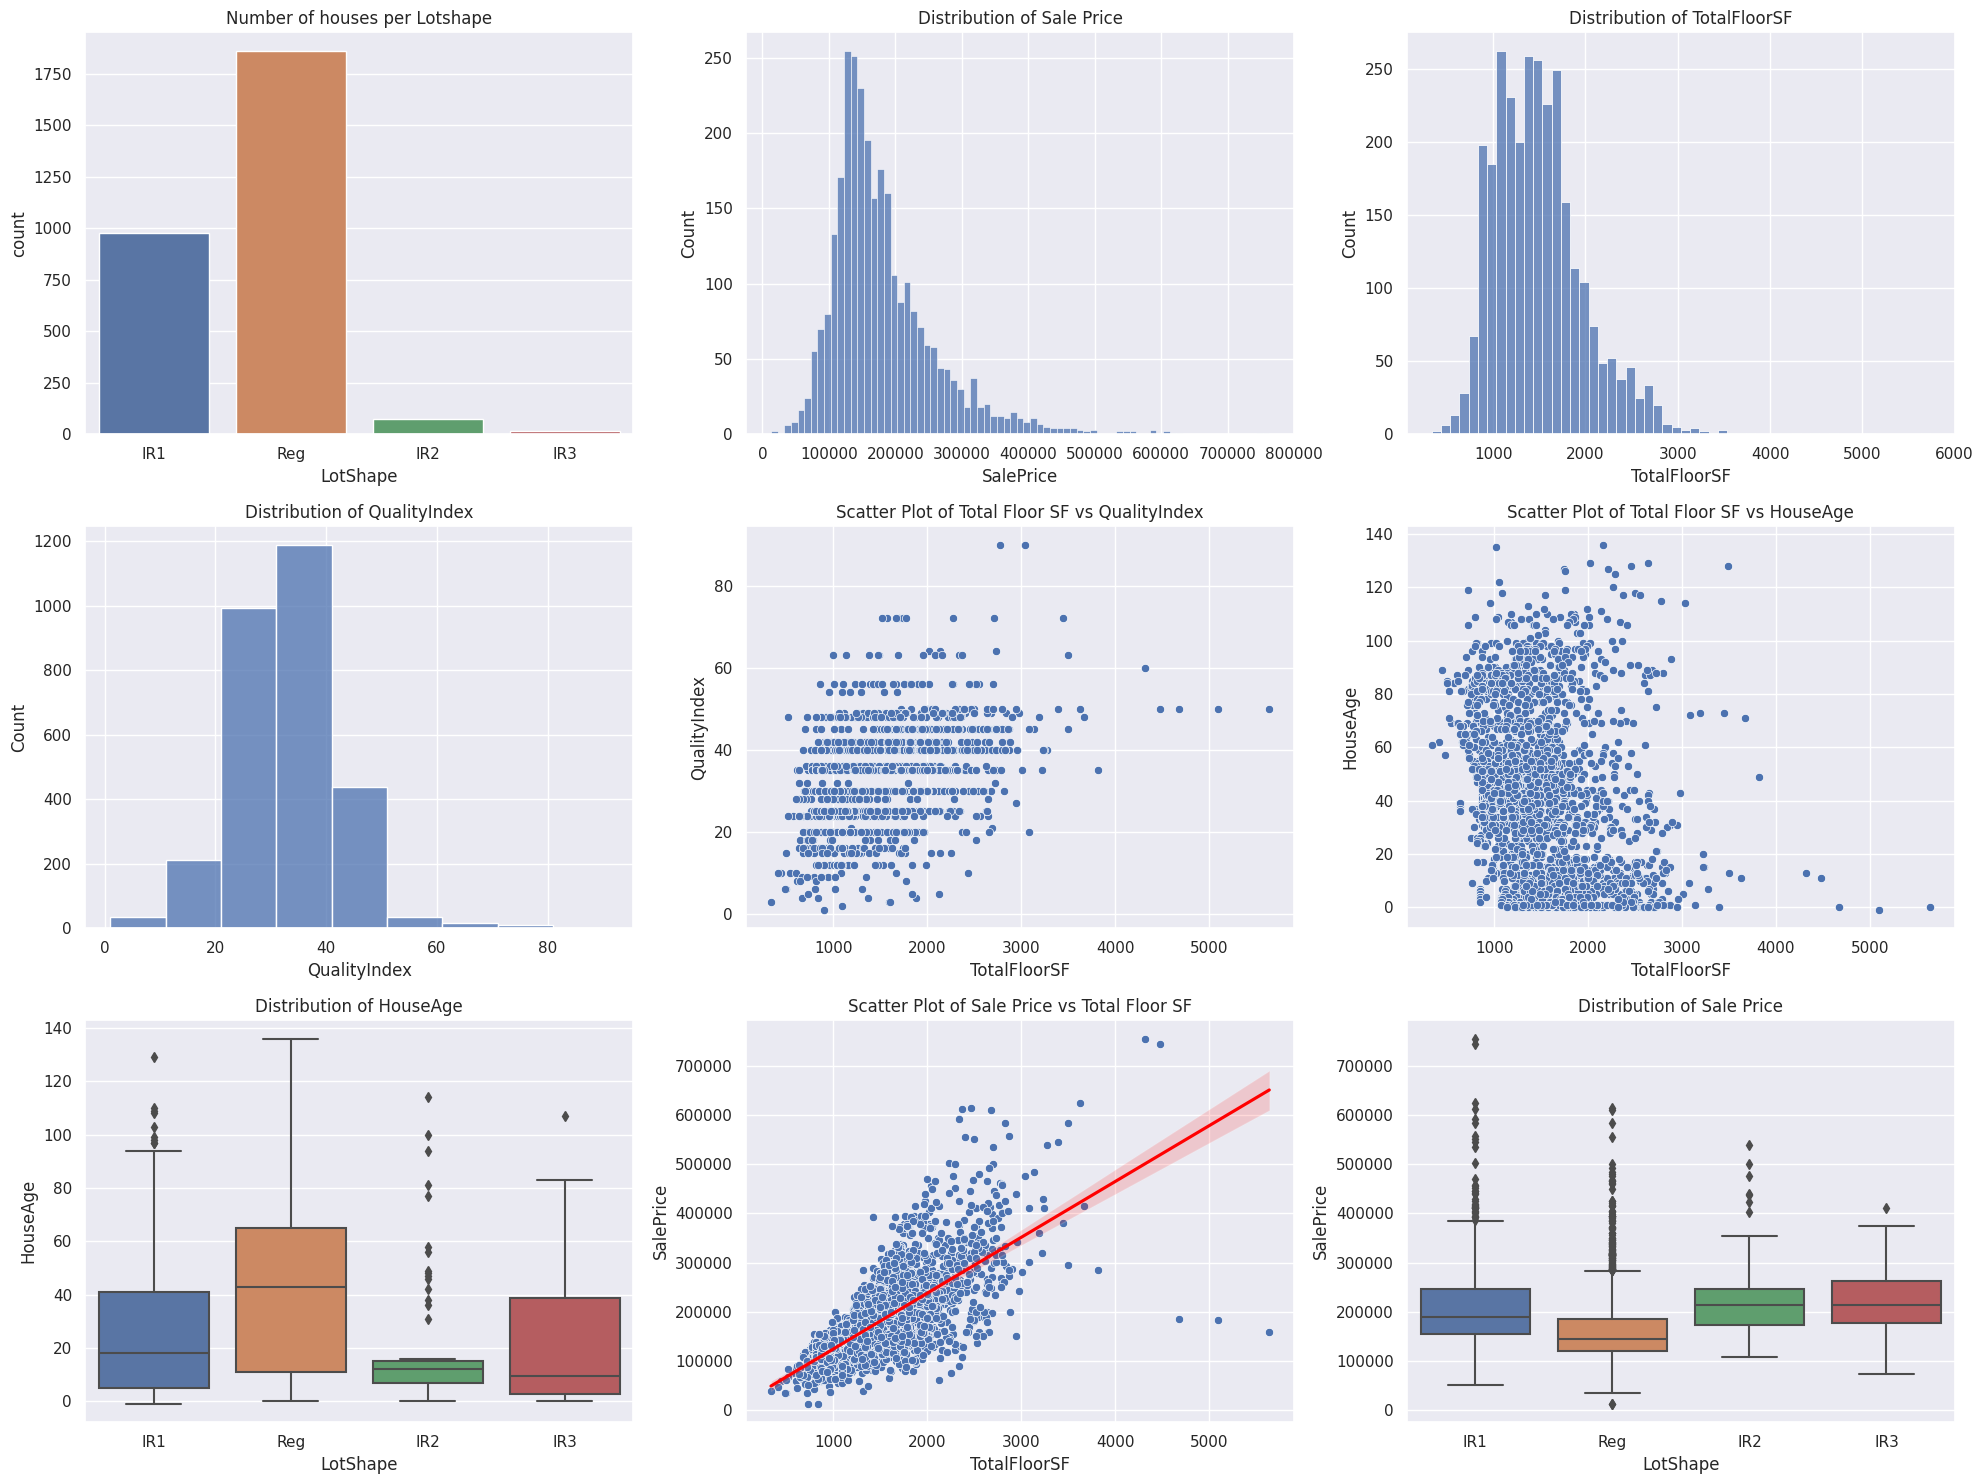

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
f, axes = plt.subplots(3, 3, figsize=(20, 15))

# Univariate EDA
sns.countplot(data=subdat, x='LotShape', ax=axes[0, 0]).set_title('Number of houses per Lotshape')

sns.histplot(data=subdat, x='SalePrice', binwidth=10000, ax=axes[0, 1]).set_title('Distribution of Sale Price')

sns.histplot(data=subdat, x='TotalFloorSF', binwidth=100, ax=axes[0, 2]).set_title('Distribution of TotalFloorSF')

sns.histplot(data=subdat, x='QualityIndex', binwidth=10, ax=axes[1, 0]).set_title('Distribution of QualityIndex')

# Bivariate EDA
sns.scatterplot(data=subdat, x='TotalFloorSF', y='QualityIndex', ax=axes[1, 1]).set_title('Scatter Plot of Total Floor SF vs QualityIndex')

sns.scatterplot(data=subdat, x='TotalFloorSF', y='HouseAge', ax=axes[1, 2]).set_title('Scatter Plot of Total Floor SF vs HouseAge')

sns.boxplot(data=subdat, x='LotShape', y='HouseAge', ax=axes[2, 0]).set_title('Distribution of HouseAge')

# Model focussed EDA
sns.scatterplot(data=subdat, x='TotalFloorSF', y='SalePrice', ax=axes[2, 1]).set_title('Scatter Plot of Sale Price vs Total Floor SF')
sns.regplot(data=subdat, x='TotalFloorSF', y='SalePrice', scatter=False, color='red', ax=axes[2, 1])

sns.boxplot(data=subdat, x='LotShape', y='SalePrice', ax=axes[2, 2]).set_title('Distribution of Sale Price')

plt.tight_layout()
plt.show()

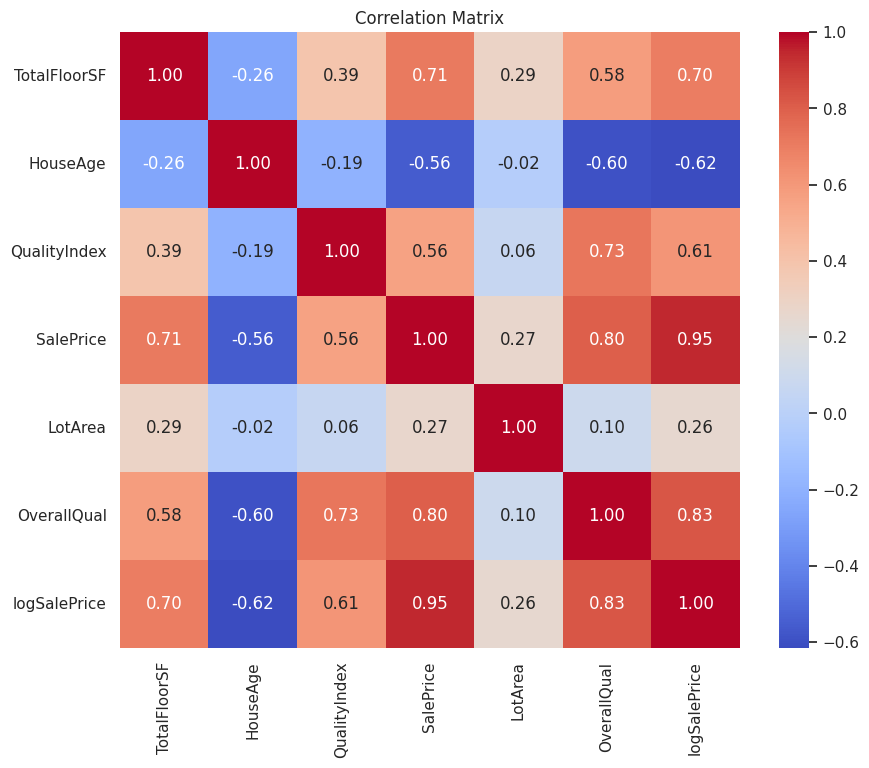

In [25]:
# Correlation plot
corr = subdatnum.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

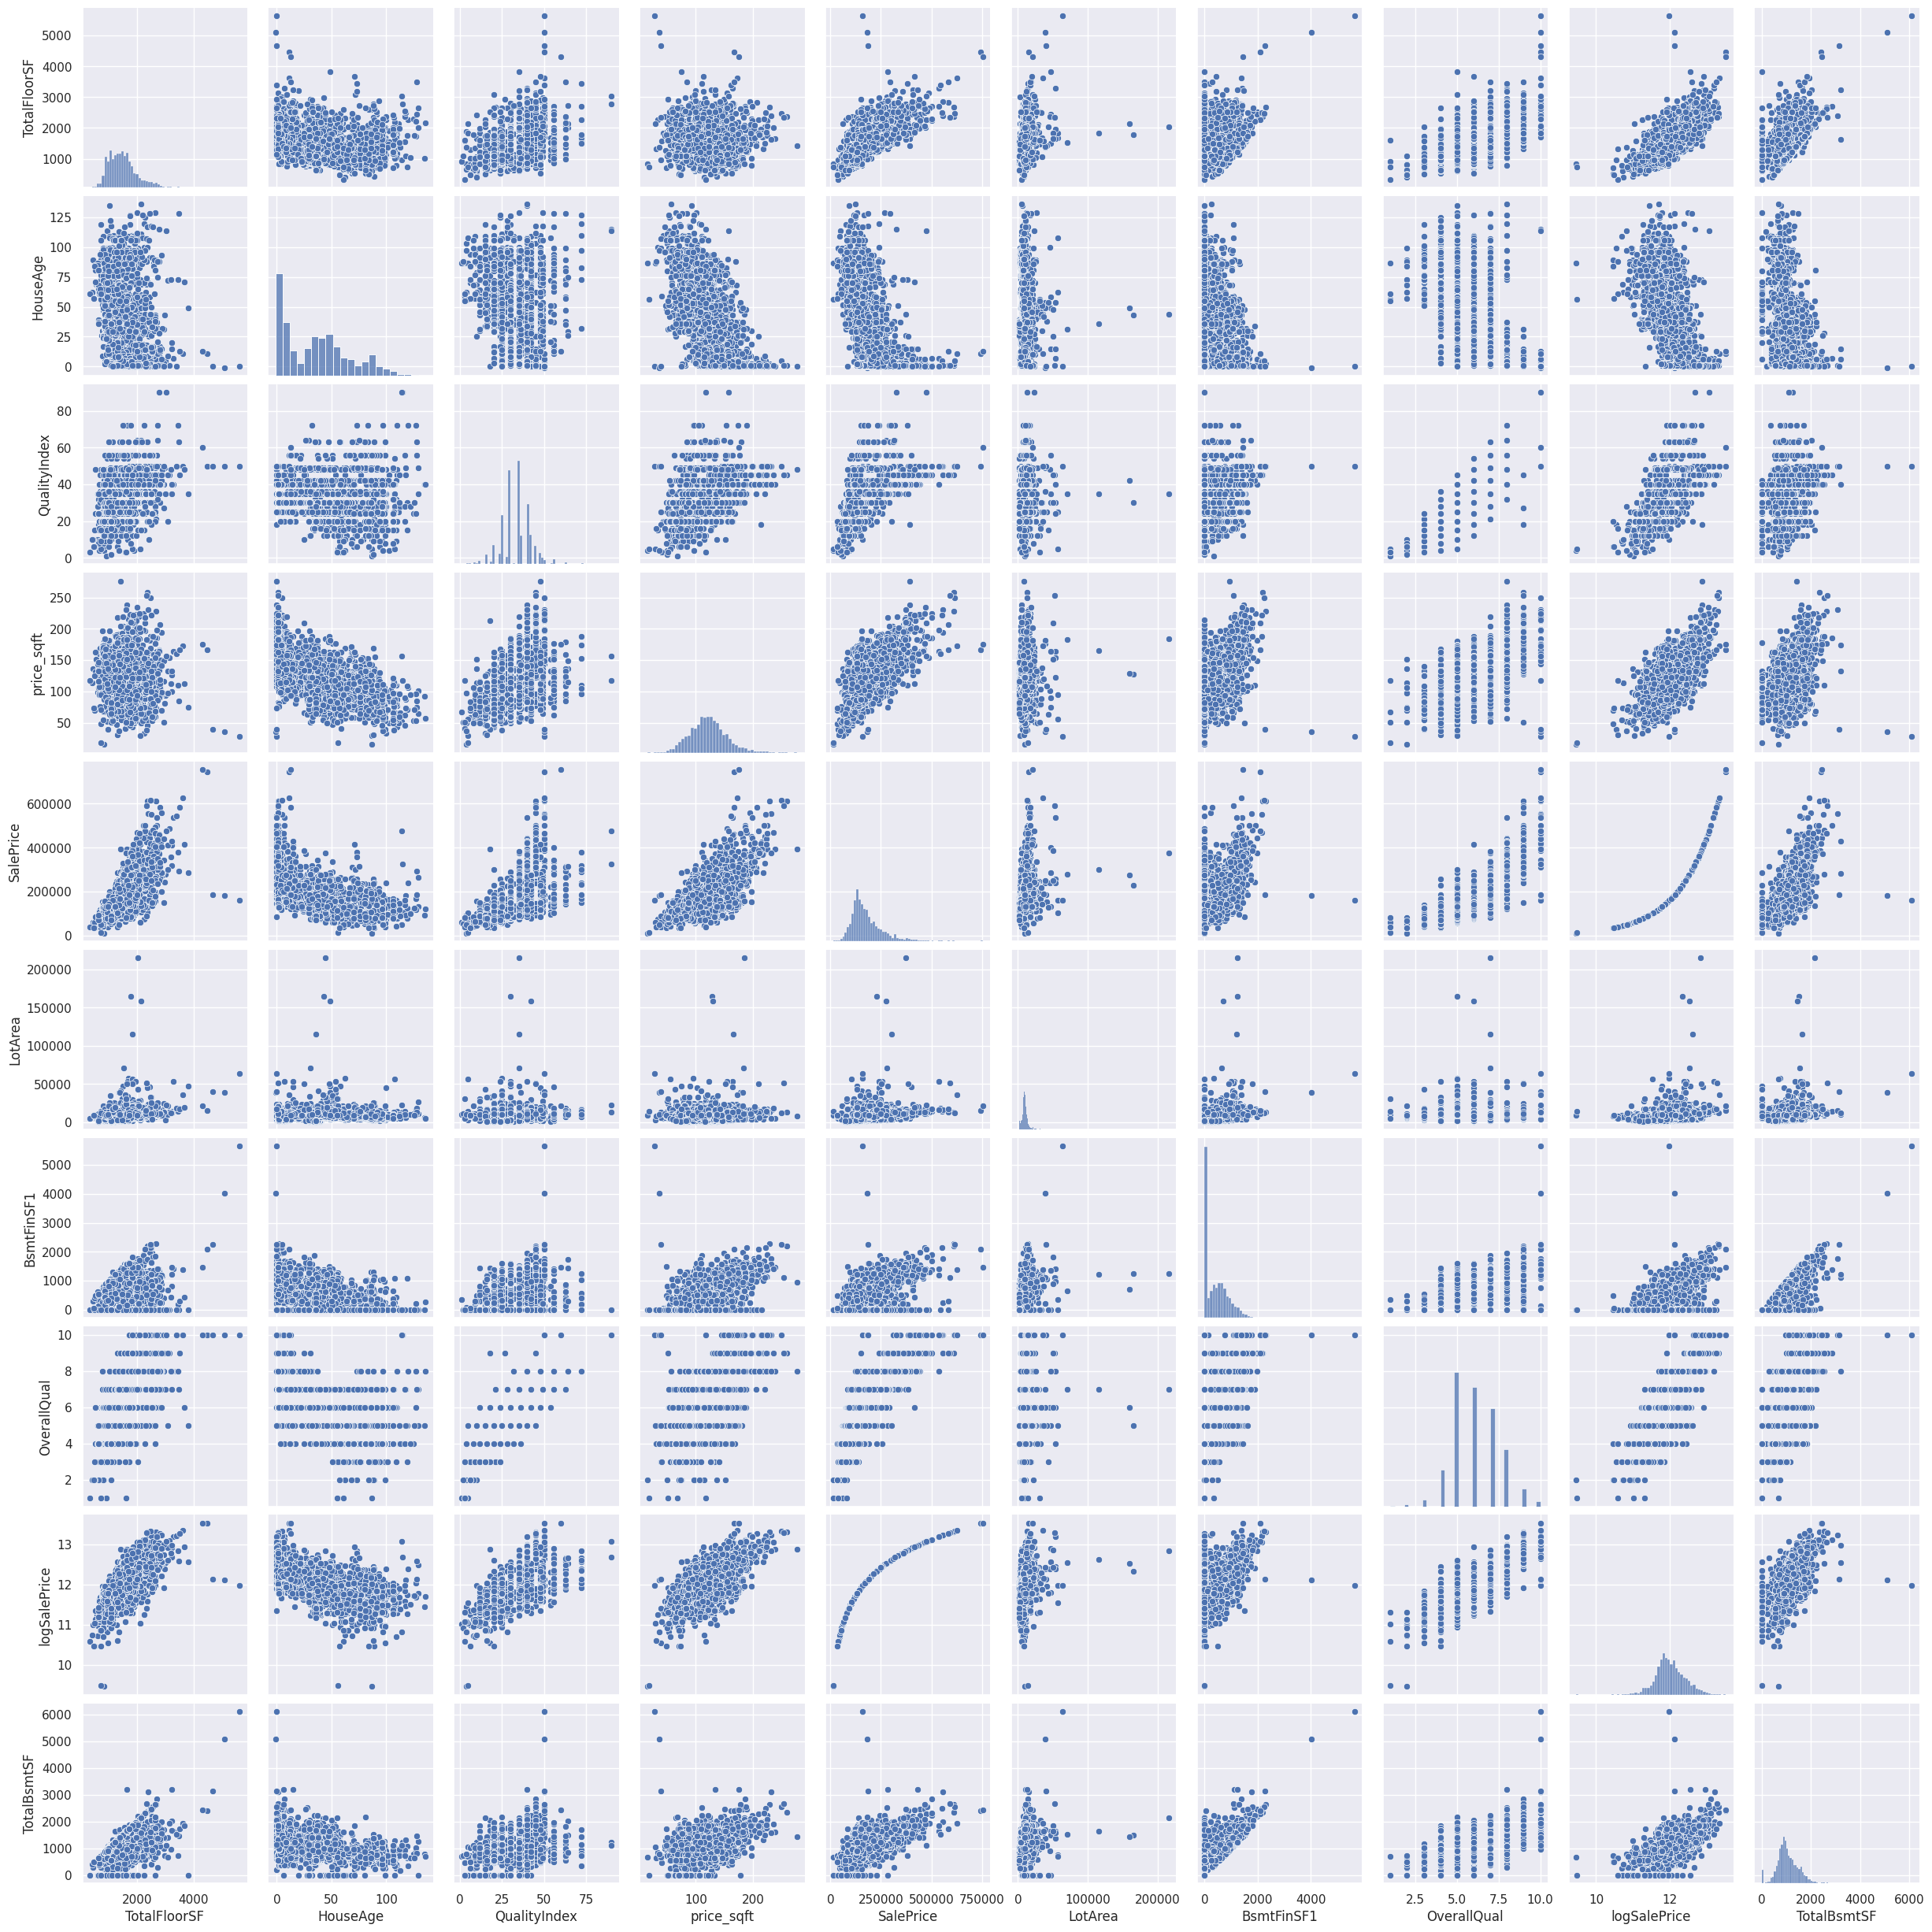

In [26]:
subdat_numeric = subdat.select_dtypes(include=np.number)
sns.pairplot(subdat_numeric)
plt.show()